# Project Milestone 2 : _Donald Trump’s Influence on the Covid Infodemic: An Assessment of a Leader’s Impact on (Mis)information Spread_

---
## Context


<img src="images/trump_sample_tweet.png">
Donald Trump’s many tweets during the Covid pandemic spread like wildfire, probably making him one of the most
influential figures during the pandemic – but in the end, was he that influential? Will causal analyses of the effect of
Trump’s tweets on Wikipedia and Google Trends pageviews show that he was leading or following online trends? Our
goal is to study the impact an influential leader can have on information spread in a
crisis with a focus on fake news, as an overload of misleading or contradictory
statements (an infodemic, as [WHO](https://www.who.int/health-topics/infodemic#tab=tab_1) calls it) are known to have a detrimental impact on crisis
management. To provide a more comprehensive insight into Trump’s actual influence
on online information spread, we would then like to compare it with that of other
factors such as mobility restrictions or key milestones (e.g. first Covid death). Trump
the Trend Maker or Trump the Follower, that is the question!


## Imports :

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact

import gensim.corpora as corpora
import gensim
from gensim.utils import simple_preprocess
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Local Modules
from extra_material.wiki_pageviews_covid.analyses.helpers.load import load_interventions, load_aggregated, load_topics, load_pca
from extra_material.wiki_pageviews_covid.analyses.helpers.vars import codes, helper_langs, interventions_helper, int_c, int_ls
from extra_material.wiki_pageviews_covid.analyses.helpers.plot import set_size, plot_dates, plot_intervention, plot_cumm_diff
from extra_material.wiki_pageviews_covid.analyses.helpers.pca import get_attention_shift_ts 
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D

from extra_material.wiki_gtrend_visualization import load_wikipedia_df, load_gtrend_df

# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

---
# Part 0: Pre-processing

### A) We start by preparing and familiarizing with our data

Our datasets :
- Covid dataset from ada class
- Donald Trump's tweet between 2019 and
  2021: [Kaggle](https://www.kaggle.com/datasets/codebreaker619/donald-trump-tweets-dataset)
- List of known fake news and their Google trends'
  reference : [GitHub](https://github.com/epfl-dlab/fact-checkers-fact-check/blob/main/data/kg_ids.json)
- Data extracted from Google Trends and Wikipedia (will be done after)

Let's present Donald Trump's tweets dataset 

In [7]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

/tmp/ipykernel_9508/2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [8]:
df.sample(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
30485,452403839250202624,"""""""@PbrunnerRr: @realDonaldTrump You should go...",f,f,Twitter for Android,32,19,2014-04-05,f
8123,1240858155472637953,RT @SenCapito: My full statement on today's vo...,t,f,Twitter for iPhone,0,2074,2020-03-20,f
22318,333066272642330625,"""""""@doralaquatics: @realDonaldTrump WooHoo! Ha...",f,f,Twitter for Android,6,8,2013-05-11,f
45318,852510810287075329,Things will work out fine between the U.S.A. a...,f,f,Twitter for iPhone,93877,19323,2017-04-13,f
52206,1173571513418756098,“What’s happening to Justice Kavanaugh is a di...,f,f,Twitter for iPhone,55247,13121,2019-09-16,f


There is no empty row in the dataset :

In [9]:
print('Number of rows with Nan value is', len(df)-(~df.isna()).prod(axis= 1).sum())

Number of rows with Nan value is 0


Let's focus on the Covid period:

In [10]:
df_covid = df[df['date'] >= '2019-12-01']
df_covid.sort_values(by='date')
df_covid.head(5)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17,f


Let's check whether Donald Trump Tweeted every day :

In [11]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')

print('Number of days where he did not tweet ' , data['id'].isna().sum())

Number of days where he did not tweet  1


Since there is only one day where he didn't tweet, we can drop this day from our dataset, it won't affect our analysis.

In [12]:
data.dropna(inplace=True)

data['per_day_tweets']= data.groupby('date')['date'].transform('count')
data['per_day_retweets']= data.groupby('date')['retweets'].transform('sum')
data['per_day_likes']= data.groupby('date')['favorites'].transform('sum')

We can have a look at the temporal evolutions of Trump's tweets :

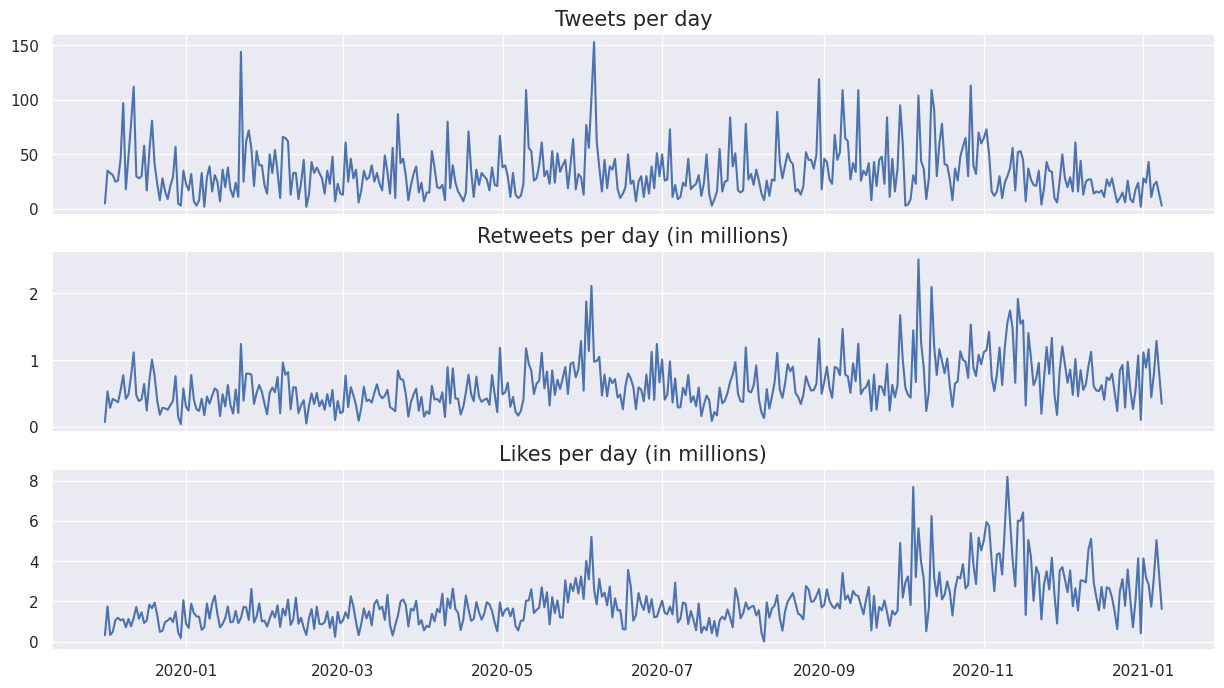

In [31]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, sharex=True, sharey=False)

axes[0].plot(data['date'], data['per_day_tweets'])
axes[0].set_title('Tweets per day', size=15)
axes[1].plot(data['date'], data['per_day_retweets']/10**6)
axes[1].set_title('Retweets per day (in millions)', size=15)
axes[2].plot(data['date'], data['per_day_likes']/10**6)
axes[2].set_title('Likes per day (in millions)', size=15)

plt.show()

Let's have an idea of the type of tweets we have :

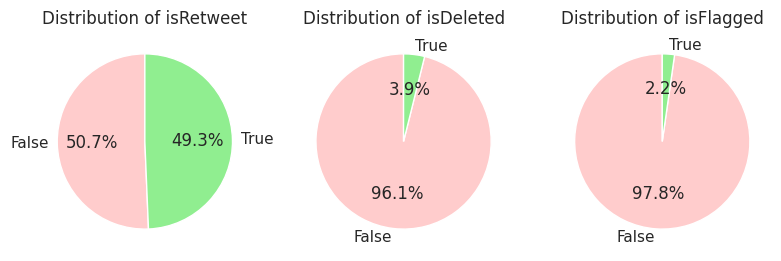

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False, figsize=(8, 12))

variables = ['isRetweet', 'isDeleted', 'isFlagged']
colors = ['#FFCCCC', 'lightgreen']

for i, var in enumerate(variables):
    ax = axes[i]
    ax.pie(data[var].value_counts(), labels=['False', 'True'], autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()


There are very few deleted tweets, though this can be an indication of misinformation spreaded by Trump.

Use spacy to get rid of stop words in the tweets. Stop words are all that words such as and, or, that, etc. that are not relevant for a tweet but are used very often.

In [33]:
#Before running following command install dictionary with:
#python -m spacy download en_core_web_sm

#download a english dictionary to make anlysis
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


Let's have a look at the most used words in Trump's tweets :

In [18]:
df_clean = data.copy()

df_clean['text'] = df_clean['text'].apply(lambda x: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',x))

df_clean['text'] = df_clean['text'].apply(lambda x: x.lower())

for punctuation in [',', '.', ':', ';', '?', '!', '"', '/', '|', "'"]:
    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(punctuation, ' '))

for word in ['@realdonaldtrump', 'realdonaldtrump', 'rt', '&amp','trump', 'thank', 'people', 'great', 's']:

    df_clean['text'] = df_clean['text'].apply(lambda x: x.replace(' '+word+' ', ' '))

df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('rt ', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('thank', ''))
df_clean['text'] = df_clean['text'].apply(lambda x: x.replace('president', ''))

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))

def remove_stopwords(texts, spacy_stopwords):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in spacy_stopwords] for doc in texts]

In [20]:
dataframe = df_clean['text'].values.tolist()
data_words = list(sent_to_words(dataframe))
data_words = remove_stopwords(data_words, spacy_stopwords)

NameError: name 'gensim' is not defined

In [21]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

NameError: name 'data_words' is not defined

As we can see, there are not that much related to covid. Though one can already spot some of his favorite topics.

Let's focus our analysis on Covid-related tweets

In [15]:
#create a list of words related to covid
list_of_words = ['covid19' ,'virus', 'vaccine','flu' ,'covid', 'lockdown', 'pandemic', 'coronavirus','corona','covid', 'quarantine', 'quarentine', 'quarantined', 'quarentined', 'quarantining', 'quarentining', 'quarantines', 'quarentines',  'quarantine',  'quarentine', 'quarantining', 'quarentining',  'quarantines', 'quarentines',  'quarantine',  'quarentine',  'quarantining', 'Quarantining', 'quarentining',  'quarantines',  'quarentines', 'quarantine', 'quarentine',  'quarantining', 'quarentining', 'quarantines', 'quarentines']

df_clean['covid_related'] = df_clean['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

df_clean['covid_related'].value_counts()

covid_related
False    12750
True       768
Name: count, dtype: int64

In [16]:
#data where covid_related is true
data_covid_rel = df_clean[df_clean['covid_related']==1]

In [17]:
df_temp = data_covid_rel[(data_covid_rel['date']>=datetime(2020,3,8))&(data_covid_rel['date']<=datetime(2020,4,24))]

Following the same process, we can have a look at the most used words in Trump's Covid related tweets :

In [18]:
dataframe = data_covid_rel['text'].values.tolist()
data_words = list(sent_to_words(dataframe))
data_words = remove_stopwords(data_words, spacy_stopwords)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


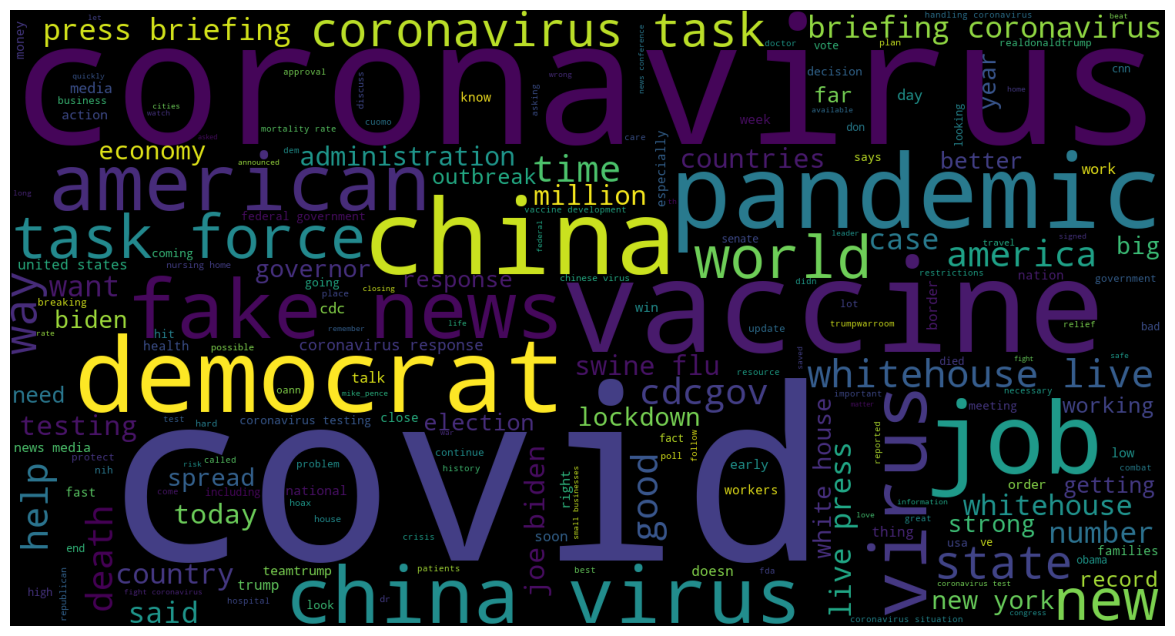

In [19]:
clean = ' '.join([sentence for sublist in data_words for sentence in sublist])

wordcloud = WordCloud(width=1500, height=800, random_state=21).generate(clean)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

This image shows a more spreaded distribution of words. Though, one can spot the importance of china,vaccine ,chinese virus or even swine flu in his tweets. Lots of words were also related to actions such as Task Force, Live Press or Briefing.

Let's find the moment when Trump tweeted the most about Covid:

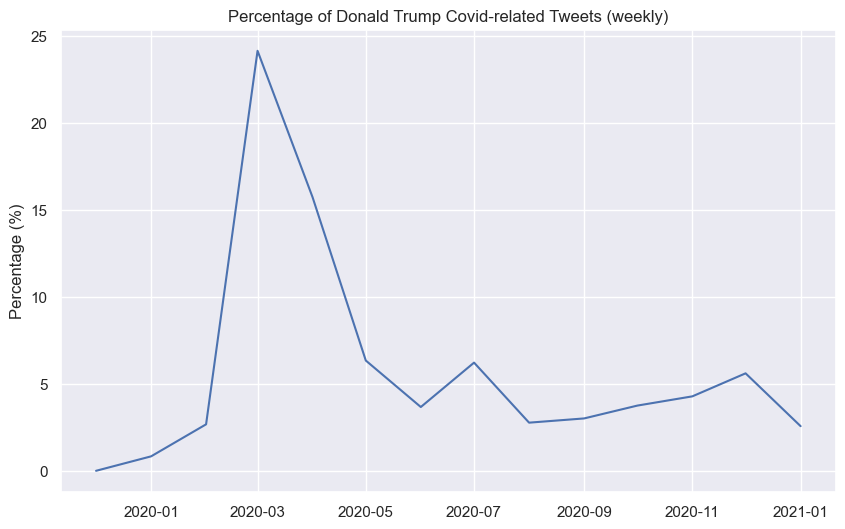

In [20]:
df_clean['month_date'] = df_clean.date.apply(lambda x: x.month)
df_clean['year_date'] = df_clean.date.apply(lambda x: x.year)
frequency_plot = df_clean.groupby(by=['month_date', 'year_date']).apply(lambda x: x.covid_related.sum() / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

#plot the percentage of covid related tweets
plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets (weekly)')
plt.show()

As we can see the highest density of covid related tweets is in March 2020, which is the beginning of the pandemic in the US. In March the percentage peaked at 20%. We can also see that the density of covid related tweets is decreasing over time.

Now let's discover if among the most retweeted and the most liked tweets there are some that are related to covid:

In [23]:
data = df_clean
data['decile_retweeted'] = pd.qcut(data['retweets'], 10, labels=False, duplicates='drop')
data['decile_favorites'] = pd.qcut(data['favorites'], 10, labels=False, duplicates='drop')

Not all tweets have the same impact on public opinion, hence we want to see in which period covid related tweets were among the most relevant, to adress importance we use retweet as a proxy.

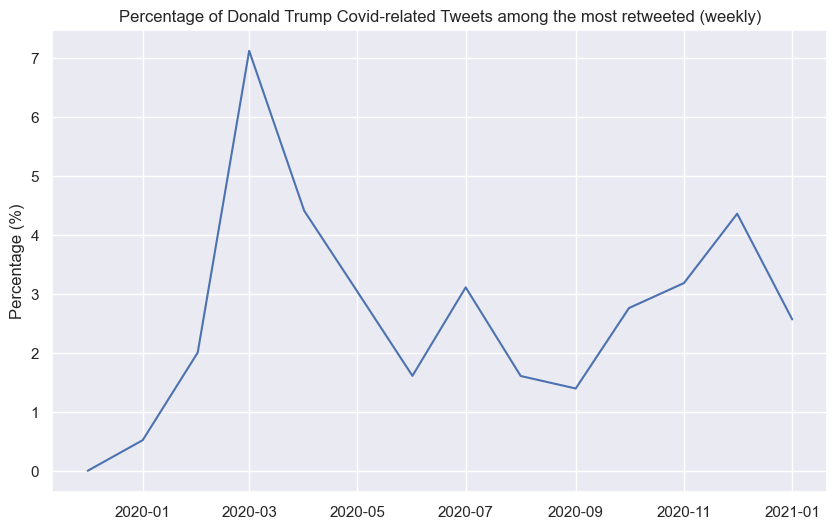

In [24]:
frequency_plot = data.groupby(by=['month_date', 'year_date']).apply(lambda x: 
                                                                    ((x.covid_related)*((x.decile_retweeted==9)|(x.decile_retweeted==8)|(x.decile_retweeted==7)|
                                                                                        (x.decile_retweeted==6)|(x.decile_retweeted==5))).sum() 
                                                                                        / x.covid_related.count()).reset_index()
frequency_plot['date'] = [datetime(year=y, month=x, day=1) for x,y in zip(frequency_plot.month_date.values, frequency_plot.year_date.values)]
frequency_plot = frequency_plot.sort_values(by='date')

plt.figure(figsize=(10, 6)) 
plt.ylabel('Percentage (%)')
plt.plot(frequency_plot.date, frequency_plot.iloc[:,2] * 100)
plt.title('Percentage of Donald Trump Covid-related Tweets among the most retweeted (weekly)')
plt.show()

**As we can see the moment were we had the highest share of covid related tweets (March 2020) is also the moment we had also the highest number of tweets related to covid.**

# Part 1: Automatized Topic clustering using latent dirichlet allocation

we slice the dataset so that we we take into account only the most interesting period related to covid, which is from start of march to late may 2020

In [33]:
df_cov_period = df_clean[(df_clean['date']>'01-03-2020')&(df_clean['date']<'31-05-2020')]

data = df_cov_period['text'].values.tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words, spacy_stopwords)

id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]

num_topics = 3

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"democrats" + 0.005*"american" + 0.004*"like" + 0.004*"biden" + '
  '0.004*"america" + 0.004*"joe" + 0.004*"new" + 0.003*"obama" + '
  '0.003*"coronavirus" + 0.003*"house"'),
 (1,
  '0.007*"today" + 0.006*"news" + 0.006*"house" + 0.005*"new" + '
  '0.005*"coronavirus" + 0.004*"impeachment" + 0.004*"whitehouse" + '
  '0.004*"white" + 0.003*"good" + 0.003*"states"'),
 (2,
  '0.007*"democrats" + 0.006*"coronavirus" + 0.005*"news" + 0.005*"whitehouse" '
  '+ 0.005*"fake" + 0.004*"impeachment" + 0.004*"american" + 0.003*"time" + '
  '0.003*"china" + 0.003*"new"')]


In [34]:
vis_data = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis_data)

c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\dandr_wh38grr\AppData\Local\Programs\Python\Python311\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.col

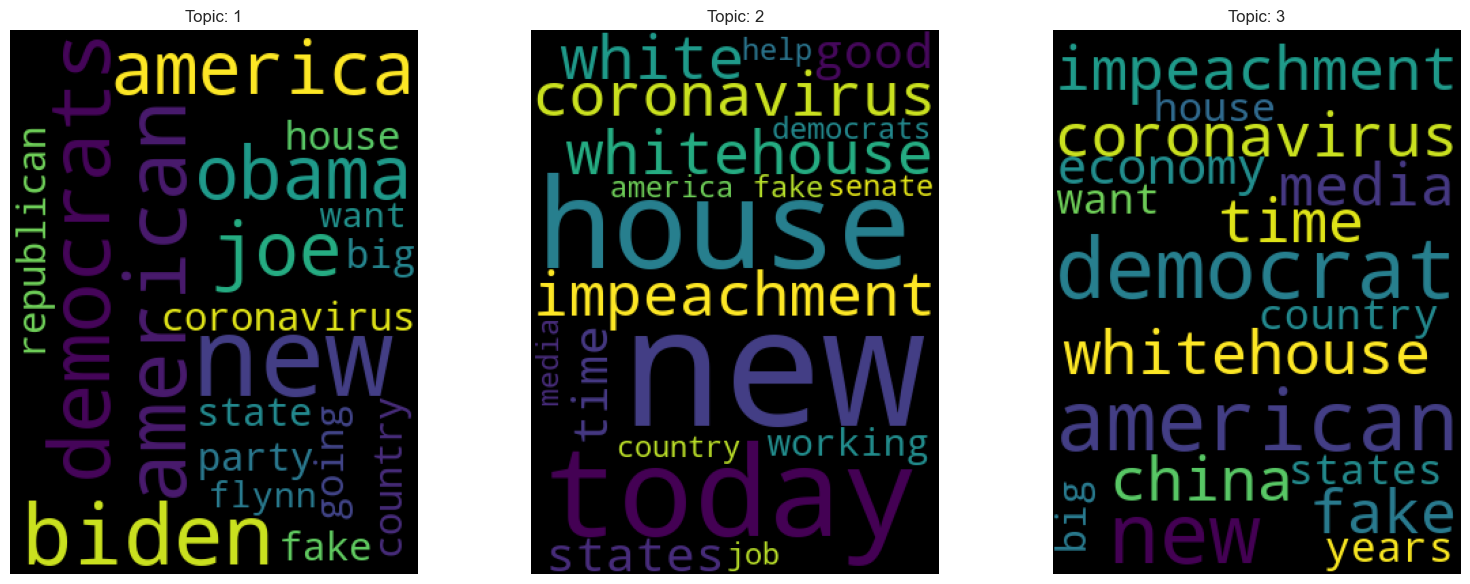

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(16, 6)) 

for topic_id, topic in enumerate(lda_model.print_topics(num_topics=num_topics, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=300, height=400, random_state=21).generate(topic_words)

    axs[topic_id].imshow(wordcloud)
    axs[topic_id].axis("off")
    axs[topic_id].set_title("Topic: {}".format(topic_id+1))

plt.tight_layout()
plt.show()

Doing an latent dirichlet analysis we can get some intuition of trump's most relevant topic of discussion. In topic 1 we can see clearly the more political oriented with words such as democrat, republicans ,biden, obama. In topic 3 there is a much more covid oriented cluster with keywords such as coronavirus, china, fake news.


___
## Mobility -> what do we keep??
We studied how Trump's tweet can affect the public debate. This part proposes to perform a causal impact analysis on alternative hypothesis. To do so, we'll study the effect of discrete event on our topics (mobility changepoints and public events in the US) and use the total trafic on Wikipedia as a time serie baseline.

The following part is reusing code and helper functions from the work [Sudden Attention Shifts on Wikipedia During the COVID-19 Crisis](https://github.com/epfl-dlab/wiki_pageviews_covid)

In [ ]:
params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': False
}

mpl.rcParams.update(params)

In [ ]:
interventions = load_interventions("extra_material/wiki_pageviews_covid/data/interventions.csv")
topics_df, topics = load_topics('extra_material/wiki_pageviews_covid/data/topics_linked.csv.xz')
agg = load_aggregated("extra_material/wiki_pageviews_covid/data/aggregated_timeseries.json.gz")
codes_order = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
dfs_pca_shift = load_pca(codes_order, pca_folder="extra_material/wiki_pageviews_covid/data/pca/")

The following plot shows the evolution of pageview on wikipedia, and the amount of them related to covid. We'll superimpose the trends on Hydroxichloroquine to spot a potential correlation. Note that since the covid fighting strategies differed from a state to another, we enriched the dataset with the date of first school closure, or first lockdown in the US.

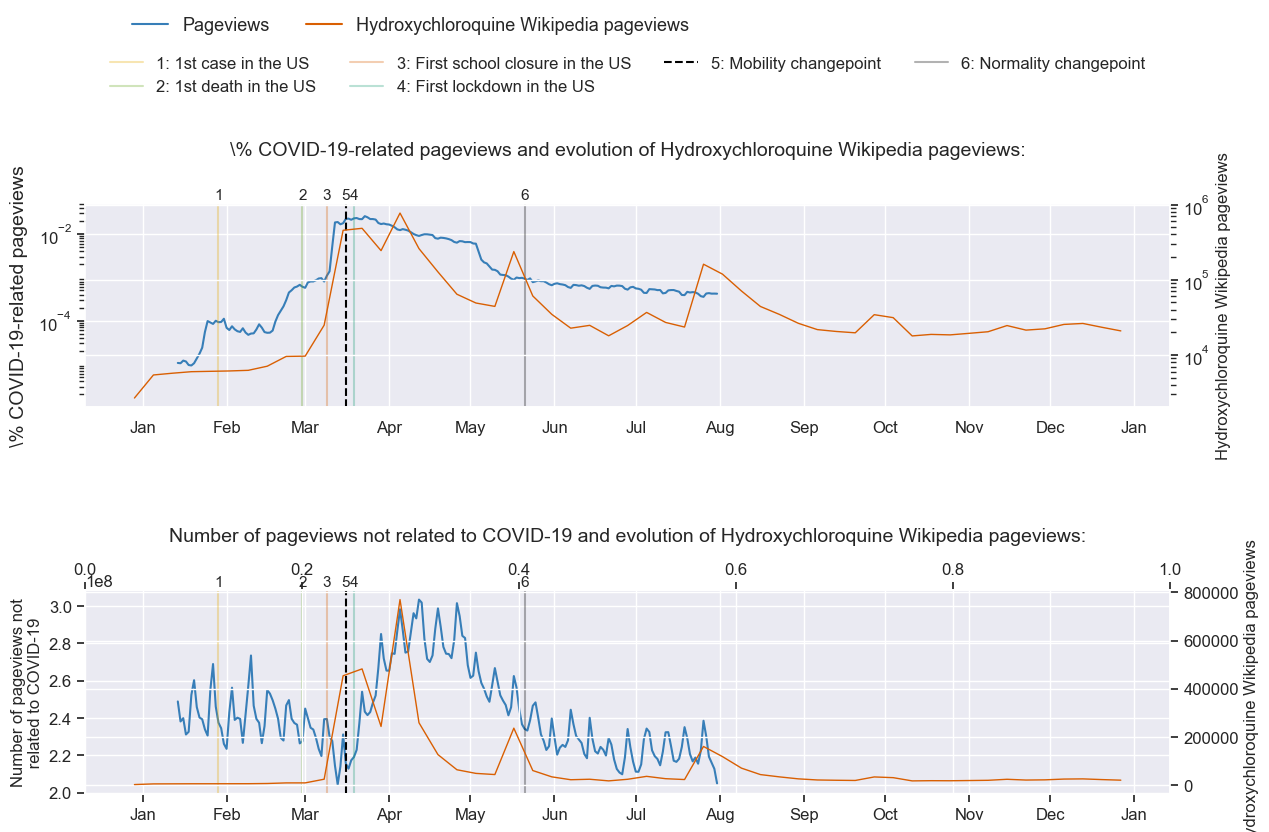

In [ ]:
idx =3
fig, axs = plt.subplots(2, 1,
                       figsize=(14, 10),
                       sharex=False,
                       gridspec_kw={"hspace": 0.9, "wspace": 0.15, "top": 0.7})
# COVID-RELATED PAGEVIEWS
ax = axs[0]
code = codes_order[idx]
ax.set_ylabel(helper_langs[code], rotation=0, ha="right", va="center", fontsize=14)
start, end = plot_dates(ax, 20200114, 20200731, 
                        agg[code]["sum"].index,
                        (agg[code]["covid"]["sum"].values + agg[code + ".m"]["covid"]["sum"].values +1) 
                        / (agg[code]["sum"].values + agg[code+".m"]["sum"].values),  sci=False, color="#377eb8")

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)

ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.set_ylabel("\% COVID-19-related pageviews", rotation=90,labelpad=14.0)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('right')
ax.set_yscale("log")
ax.set_ylim([10**(-6), 5* 10**(-2)])
ax.set_yticks([10**(-4), 10**(-2)])

ax02 = ax.twinx() 
ax02.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax02.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax02.set_yscale('log')
ax02.tick_params(axis ='y') 

# NON COVID-RELATED PAGEVIEWS
ax = axs[1]

ax_twin = ax.twiny()

start, end = plot_dates(ax, 20200114, 20200731, 
                    agg[code]["sum"].index, agg[code]["sum"].values + agg[code + ".m"]["sum"].values -
                    agg[code]["covid"]["sum"].values - agg[code +".m"]["covid"]["sum"].values, 
                        color="#377eb8", sci=False)

plot_intervention(ax, interventions, code, "all", interventions_helper, int_ls, int_c)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

for ax_t in [ax, ax_twin]:
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('right')

ax.set_ylabel("Number of pageviews not\n related to COVID-19 ")

ax12 = ax.twinx() 
ax12.set_ylabel('Hydroxychloroquine Wikipedia pageviews') 
ax12.plot(weekly_wikipedia_hydro_df['Views'], color='#d95f02', linewidth=1)
ax12.tick_params(axis ='y') 

#General labels:
axs[0].set_title("\% COVID-19-related pageviews and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)
axs[1].set_title("Number of pageviews not related to COVID-19 and evolution of Hydroxychloroquine Wikipedia pageviews:",pad=35)

lines = [
    Line2D([0], [0], color="#377eb8", lw=1.5, ls="-"),
    Line2D([0], [0], color='#d95f02', lw=1.5, ls="-")
]

axs[0].legend(
    handles=lines,
    labels=["Pageviews","Hydroxychloroquine Wikipedia pageviews"],
    loc='upper center', bbox_to_anchor=(0.3, 2),
    ncol=3, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=13
)
lines_interv = [Line2D([0], [0], color=int_c[x], ls=int_ls[x], alpha=0.3 if x != "Mobility" else 1.) 
                for x, _ in interventions_helper.items()]

axs[1].legend(
    handles= lines_interv,
    labels=["{}: {}".format(v, 
                            k.replace("Mobility", "Mobility changepoint")\
                            .replace("Normalcy", "Normality changepoint"))
            for k, v in interventions_helper.items()],
    loc='upper center', bbox_to_anchor=(.5,3.7),
    ncol=4, fancybox=False, shadow=False,
    frameon=False, edgecolor=None, fontsize=12
)


Both plots allows to visually correlate interventions and online searches. For example, as we can observe, the first mobility changepoint have an important impact on online searches, and represent the time were searches were related to covid were maximum. This interventions will be used right below in Granger cauality test to assess their imp

As we can see, Hydroxychloroquine topic pageviews seems to follow the global trend of topics related to covid with more local peaks. These series will be compared right after in a causal analysis.

Pageviews of topic not related to covid could be used as a baseline series showing the increase of online traffic. This could be used in a future analysis.

# Part 2: Etienne's'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# Local Modules
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D


# Granger test between GTrends views and tweets
import statsmodels.api as sm

## Data parsing

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_93383/2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [3]:
df_covid = df[df['date'] >= '2019-12-01']

In [4]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')
data.dropna(inplace=True)

In [5]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [6]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

## Sentiment analysis 

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Etienne/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
data['scores'] = data['text'].apply(lambda Description: sid.polarity_scores(Description))  

#calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,'sentiment_type']='POSITIVE'
data.loc[data.compound==0,'sentiment_type']='NEUTRAL'
data.loc[data.compound<0,'sentiment_type']='NEGATIVE'

## Covid related

In [9]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [10]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]

t-test between covid related and non related mean of retweets :

In [11]:
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]
comparison_covid = pd.DataFrame({'Covid related':data_covid_rel.retweets, 'Non covid related':data_not_covid_rel.retweets})

t_stat, p_value_covid = ttest_ind(data_covid_rel.retweets, data_not_covid_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_covid.round(5))

The p-value of the t-test is 0.0


## LeakTheory related

In [12]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())


Number of tweets talking about COVID-19 lab leak theory is:  44


In [13]:
data_Leaktheory_rel = data[data['Leaktheory']==1]
data_not_Leaktheory_rel = data[data['Leaktheory']==0]
comparison_Leaktheory = pd.DataFrame({'Leaktheory related':data_Leaktheory_rel.retweets, 'Non Leaktheory related':data_not_Leaktheory_rel.retweets})
#sns.pointplot(data=comparison_Leaktheory, estimator='mean', errorbar=('ci', 95), color = 'r')
#plt.title('Comparison of retweets (errorbar = CI 95%)', size=13)
#plt.ylabel('Number of retweets', size=12)
#plt.show()
t_stat, p_value_Leaktheory = ttest_ind(data_Leaktheory_rel.retweets, data_not_Leaktheory_rel.retweets, equal_var=False)
print('The p-value is', p_value_Leaktheory.round(5))

The p-value is 2e-05


## Swine flu related

In [14]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col

In [15]:
data_Swineflu_rel = data[data['Swineflu']==1]
data_not_Swineflu_rel = data[data['Swineflu']==0]
comparison_Swineflu = pd.DataFrame({'Swineflu related':data_Swineflu_rel.retweets, 'Non Swineflu related':data_not_Swineflu_rel.retweets})

t_stat, p_value_Swineflu = ttest_ind(data_Swineflu_rel.retweets, data_not_Swineflu_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Swineflu.round(5))

The p-value of the t-test is 0.00485


## Hydroxychloroquine related

In [16]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [17]:
data_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==1]
data_not_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==0]
comparison_Hydroxychloroquine = pd.DataFrame({'Hydroxychloroquine related':data_Hydroxychloroquine_rel.retweets, 'Non Hydroxychloroquine related':data_not_Hydroxychloroquine_rel.retweets})

t_stat, p_value_Hydroxychloroquine = ttest_ind(data_Hydroxychloroquine_rel.retweets, data_not_Hydroxychloroquine_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Hydroxychloroquine.round(5))

The p-value of the t-test is 0.31876


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
import re
import json
import spacy
import string
import wordcloud 
from wordcloud import WordCloud
from causalimpact import CausalImpact
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# Local Modules
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D


# Granger test between GTrends views and tweets
import statsmodels.api as sm

## Data parsing

In [2]:
# build a personalyze data parser
custom_date = lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d')
df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)

/var/folders/g4/t17nc9bs2zqcfjn9vq_f93b80000gn/T/ipykernel_93383/2600807054.py:3: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('extra_material/tweets.csv', parse_dates=['date'], date_parser=custom_date)


In [3]:
df_covid = df[df['date'] >= '2019-12-01']

In [4]:
time_span = pd.date_range(start = min(df_covid['date']), end = max(df_covid['date']), freq='D')

data=df_covid.copy()
data = pd.merge(data, pd.DataFrame(time_span, columns=['date']), on='date', how='right')
data.dropna(inplace=True)

In [5]:
nlp = spacy.load('en_core_web_sm')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))

Number of stop words: 326


In [6]:
#all tweets in one string
result_text = ' '.join(data['text'])

def remove_stopwords(chunk):
    return ' '.join([token.text for token in chunk if (not token.is_stop)])

#the text we have is too big to process it at once, so we split it into chunks
chunk_size = 100000
chunks = [result_text[i:i+chunk_size] for i in range(0, len(result_text), chunk_size)]
processed_chunks = [nlp(chunk) for chunk in chunks]
processed_chunks_no_stopwords = [remove_stopwords(chunk) for chunk in processed_chunks]

#manually clean text from links, punctuation, etc.
clean = ' '.join(processed_chunks_no_stopwords)
clean= re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',clean)#remove links
clean= clean.translate(str.maketrans('', '', string.punctuation))#remove punctuation
clean = clean.replace('amp', '')
clean = clean.replace('RT', '')
clean = clean.replace('realDonaldTrump', '')

## Sentiment analysis 

In [7]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Etienne/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
data['scores'] = data['text'].apply(lambda Description: sid.polarity_scores(Description))  

#calculate the sentiment score which is a combination of positive, negative and neutral(not mean)
data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
data['sentiment_type']=''
data.loc[data.compound>0,'sentiment_type']='POSITIVE'
data.loc[data.compound==0,'sentiment_type']='NEUTRAL'
data.loc[data.compound<0,'sentiment_type']='NEGATIVE'

## Covid related

In [9]:
#create a list of words related to covid
list_of_words = ['Covid19' ,'virus', 'vaccine', 'Flu', 'Covid', 'lockdown', 'pandemic', 'coronavirus', 'Coronavirus', 'Corona', 'corona', 'COVID19', 'COVID', 'covid', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantined', 'Quarantined', 'quarentined', 'Quarentined', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines', 'quarantine', 'Quarantine', 'quarentine', 'Quarentine', 'quarantining', 'Quarantining', 'quarentining', 'Quarentining', 'quarantines', 'Quarantines', 'quarentines', 'Quarentines']
data['covid_related'] = data['text'].apply(lambda x: True if any(word in x for word in list_of_words) else False)

data['covid_related'].value_counts()

covid_related
False    12874
True       644
Name: count, dtype: int64

In [10]:
#data where covid_related is true
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]

t-test between covid related and non related mean of retweets :

In [11]:
data_covid_rel = data[data['covid_related']==1]
data_not_covid_rel = data[data['covid_related']==0]
comparison_covid = pd.DataFrame({'Covid related':data_covid_rel.retweets, 'Non covid related':data_not_covid_rel.retweets})

t_stat, p_value_covid = ttest_ind(data_covid_rel.retweets, data_not_covid_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_covid.round(5))

The p-value of the t-test is 0.0


## LeakTheory related

In [12]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())


Number of tweets talking about COVID-19 lab leak theory is:  44


In [13]:
data_Leaktheory_rel = data[data['Leaktheory']==1]
data_not_Leaktheory_rel = data[data['Leaktheory']==0]
comparison_Leaktheory = pd.DataFrame({'Leaktheory related':data_Leaktheory_rel.retweets, 'Non Leaktheory related':data_not_Leaktheory_rel.retweets})
#sns.pointplot(data=comparison_Leaktheory, estimator='mean', errorbar=('ci', 95), color = 'r')
#plt.title('Comparison of retweets (errorbar = CI 95%)', size=13)
#plt.ylabel('Number of retweets', size=12)
#plt.show()
t_stat, p_value_Leaktheory = ttest_ind(data_Leaktheory_rel.retweets, data_not_Leaktheory_rel.retweets, equal_var=False)
print('The p-value is', p_value_Leaktheory.round(5))

The p-value is 2e-05


## Swine flu related

In [14]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col

In [15]:
data_Swineflu_rel = data[data['Swineflu']==1]
data_not_Swineflu_rel = data[data['Swineflu']==0]
comparison_Swineflu = pd.DataFrame({'Swineflu related':data_Swineflu_rel.retweets, 'Non Swineflu related':data_not_Swineflu_rel.retweets})

t_stat, p_value_Swineflu = ttest_ind(data_Swineflu_rel.retweets, data_not_Swineflu_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Swineflu.round(5))

The p-value of the t-test is 0.00485


## Hydroxychloroquine related

In [16]:
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = data['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# create a new column with the result of the analysis
new_col = analyze.reindex(data.index, fill_value=False)
data['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', data['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [17]:
data_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==1]
data_not_Hydroxychloroquine_rel = data[data['Hydroxychloroquine']==0]
comparison_Hydroxychloroquine = pd.DataFrame({'Hydroxychloroquine related':data_Hydroxychloroquine_rel.retweets, 'Non Hydroxychloroquine related':data_not_Hydroxychloroquine_rel.retweets})

t_stat, p_value_Hydroxychloroquine = ttest_ind(data_Hydroxychloroquine_rel.retweets, data_not_Hydroxychloroquine_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_Hydroxychloroquine.round(5))

The p-value of the t-test is 0.31876


## Biden related

In [18]:
biden = ['Joe Biden','biden','joe','Joe','Biden','sleepy']
analyze_biden = data['text'].apply(lambda x: True if any(word in x for word in biden) else False)

# create a new column with the result of the analysis
new_col = analyze_biden.reindex(data.index, fill_value=False)
data['biden'] = new_col
print('Number of tweets talking about biden is: ', data['biden'].sum())


Number of tweets talking about biden is:  1135


In [19]:
data_biden_rel = data[data['biden']==1]
data_not_biden_rel = data[data['biden']==0]
comparison_biden = pd.DataFrame({'biden related':data_biden_rel.retweets, 'Non biden related':data_not_biden_rel.retweets})

t_stat, p_value_biden = ttest_ind(data_biden_rel.retweets, data_not_biden_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_biden.round(5))

The p-value of the t-test is 0.0


## Democrats related

In [20]:
democrats = ['Democrats','democrats','Dems','dems']
analyze_democrats = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_democrats.reindex(data.index, fill_value=False)
data['democrats'] = new_col
print('Number of tweets talking about democrats is: ', data['democrats'].sum())

Number of tweets talking about democrats is:  878


In [21]:
data_democrats_rel = data[data['democrats']==1]
data_not_democrats_rel = data[data['democrats']==0]
comparison_democrats = pd.DataFrame({'democrats related':data_democrats_rel.retweets, 'Non democrats related':data_not_democrats_rel.retweets})

t_stat, p_value_democrats = ttest_ind(data_democrats_rel.retweets, data_not_democrats_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_democrats.round(5))

The p-value of the t-test is 0.92457


## Vaccines related

In [22]:
vaccines = ['vaccines','Vaccines','vax','Vax','vaccin']
analyze_vaccines = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_vaccines.reindex(data.index, fill_value=False)
data['vaccines'] = new_col
print('Number of tweets talking about vaccines of the t-test is: ', data['vaccines'].sum())

Number of tweets talking about vaccines of the t-test is:  878


In [23]:
data_vaccines_rel = data[data['vaccines']==1]
data_not_vaccines_rel = data[data['vaccines']==0]
comparison_vaccines = pd.DataFrame({'vaccines related':data_vaccines_rel.retweets, 'Non vaccines related':data_not_vaccines_rel.retweets})


t_stat, p_value_vaccines = ttest_ind(data_vaccines_rel.retweets, data_not_vaccines_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_vaccines.round(5))

The p-value of the t-test is 0.92457


## Aggregate results into more general categories:

In [24]:
data['is_fake_news'] = (data['Hydroxychloroquine']|data['Swineflu']|data['Leaktheory'])
data['is_democrats_related'] = (data['biden']|data['democrats'])

In [25]:
data['is_democrats_related'] .sum()

1936

In [26]:
data_fake_news_rel = data[data['is_fake_news']==1]
data_not_fake_news_rel = data[data['is_fake_news']==0]
comparison_fake_news = pd.DataFrame({'fake_news related':data_fake_news_rel.retweets, 'Non fake_news related':data_not_fake_news_rel.retweets})


t_stat, p_value_fake_news = ttest_ind(data_fake_news_rel.retweets, data_not_fake_news_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_fake_news.round(5))

The p-value of the t-test is 8e-05


## Plots of number of rewteets by topics:

[Text(0, 0.5, 'Number of retweets')]

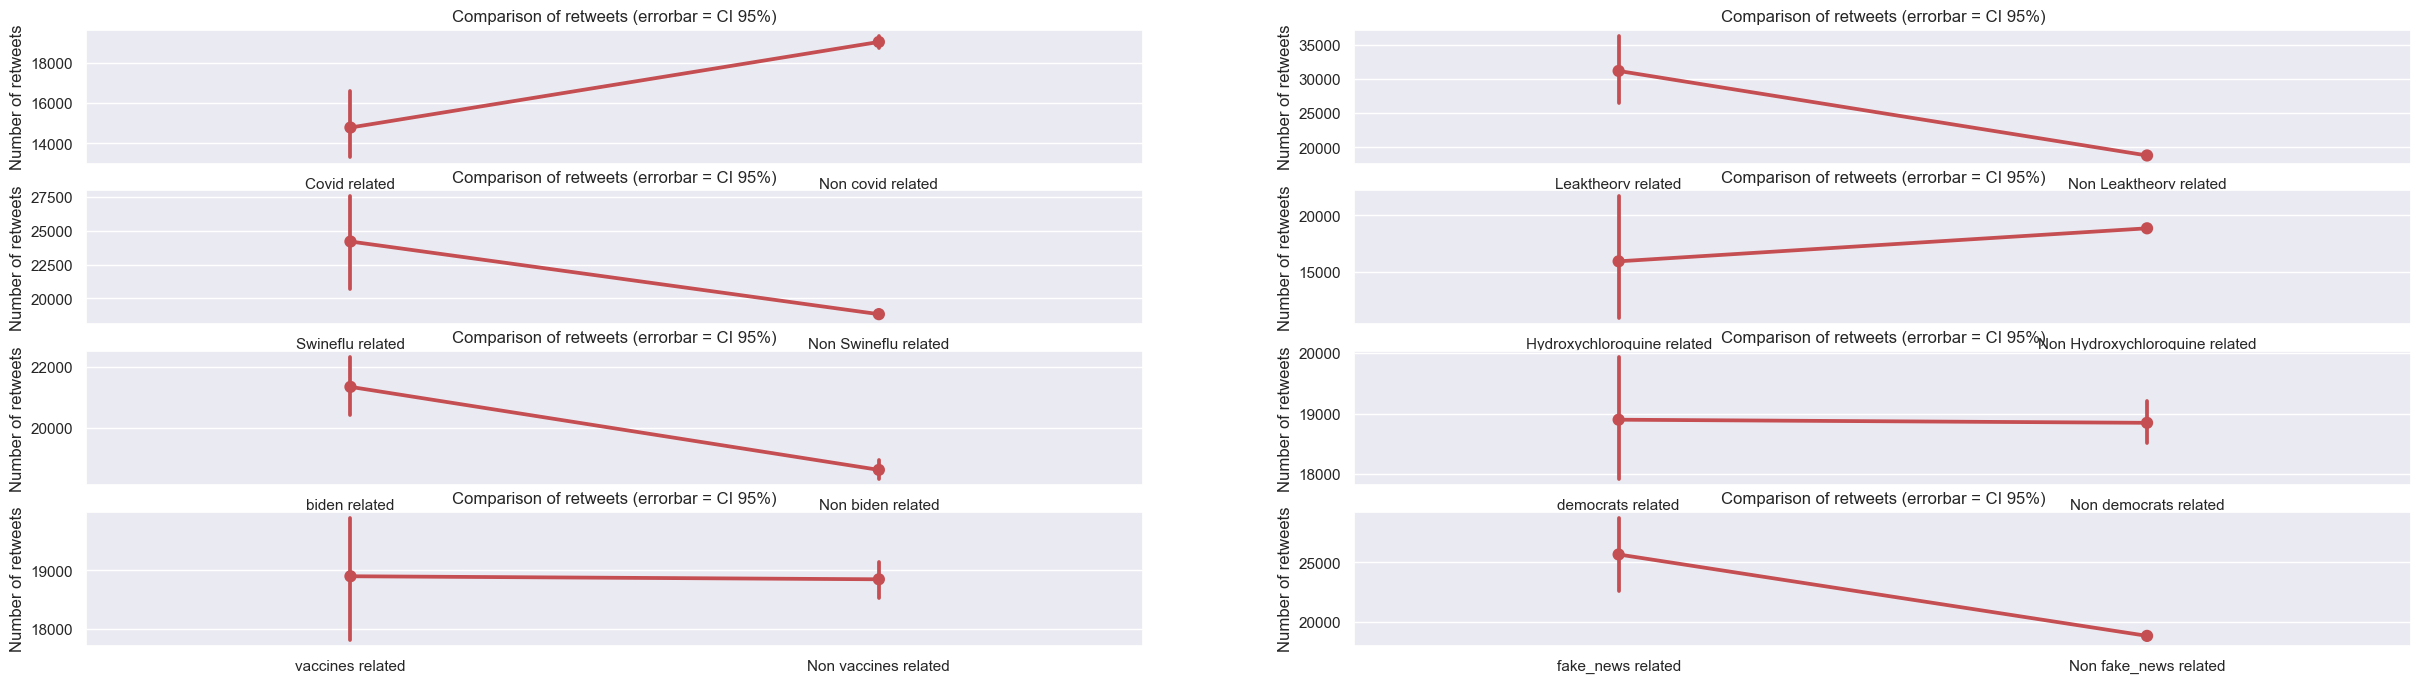

In [27]:
fig, axs = plt.subplots(4, 2,figsize=(30,8))

ax0 = sns.pointplot(data=comparison_covid, ax=axs[0, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax0 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax0 .set(ylabel='Number of retweets')

ax1 = sns.pointplot(data=comparison_Leaktheory,ax=axs[0, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax1 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax1 .set(ylabel='Number of retweets')

ax2 = sns.pointplot(data=comparison_Swineflu, ax=axs[1, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax2 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax2 .set(ylabel='Number of retweets')

ax3 = sns.pointplot(data=comparison_Hydroxychloroquine, ax= axs[1, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax3 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax3 .set(ylabel='Number of retweets')

ax4 = sns.pointplot(data=comparison_biden,ax=axs[2, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax4 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax4 .set(ylabel='Number of retweets')

ax5 = sns.pointplot(data=comparison_democrats, ax=axs[2, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax5 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax5 .set(ylabel='Number of retweets')

ax6 = sns.pointplot(data=comparison_vaccines, ax=axs[3, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax6 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax6 .set(ylabel='Number of retweets')

ax7 = sns.pointplot(data=comparison_fake_news, ax=axs[3, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax7 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax7 .set(ylabel='Number of retweets')

## Regression to disentangle categories into predicting the number of retweets:

In [28]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     22.14
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.71e-14
Time:                        10:35:50   Log-Likelihood:            -1.5163e+05
No. Observations:               13518   AIC:                         3.033e+05
Df Residuals:                   13514   BIC:                         3.033e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [29]:
mod_retweets = smf.ols(formula='retweets ~ C(covid_related)+C(is_fake_news)+C(sentiment_type)', data=data)

In [30]:
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     29.59
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.55e-24
Time:                        10:35:50   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13513   BIC:                         3.033e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Compare number of retweets per categories :

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

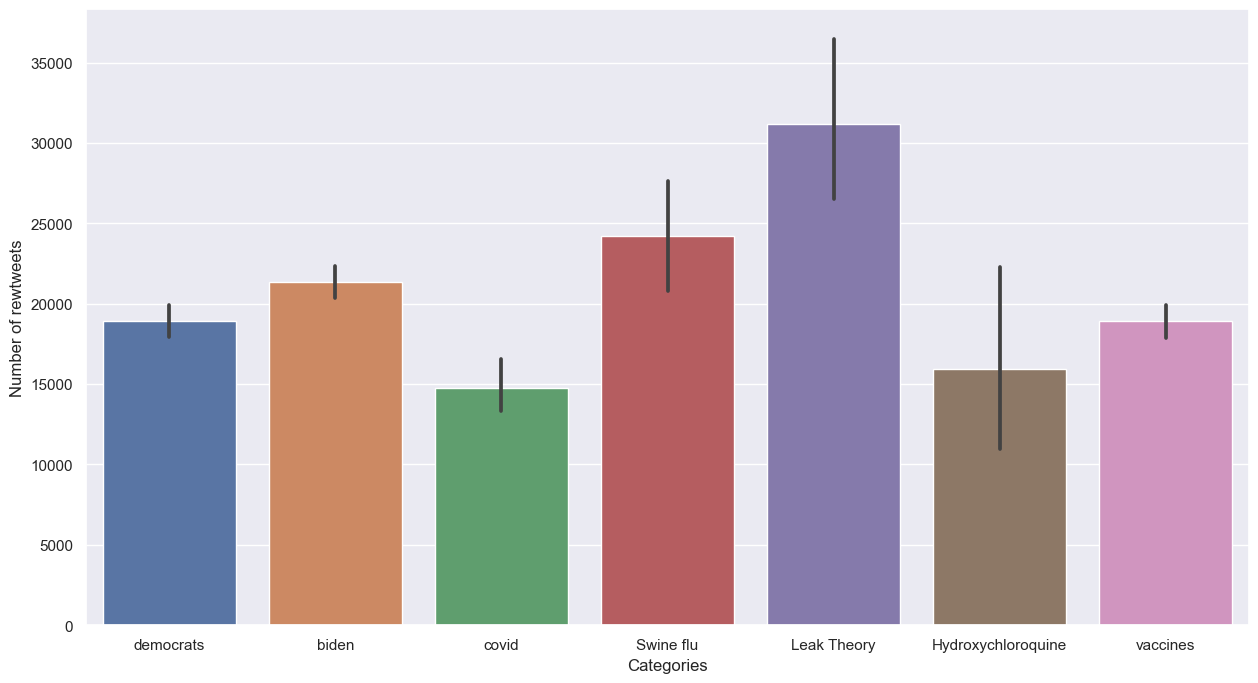

In [31]:
compare_retweets = pd.DataFrame({'democrats':data_democrats_rel.retweets,'biden':data_biden_rel.retweets,
                    'covid':data_covid_rel.retweets,'Swine flu':data_Swineflu_rel.retweets,
                     'Leak Theory':data_Leaktheory_rel.retweets,'Hydroxychloroquine':data_Hydroxychloroquine_rel.retweets,
                               'vaccines':data_vaccines_rel.retweets})

ax = sns.barplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

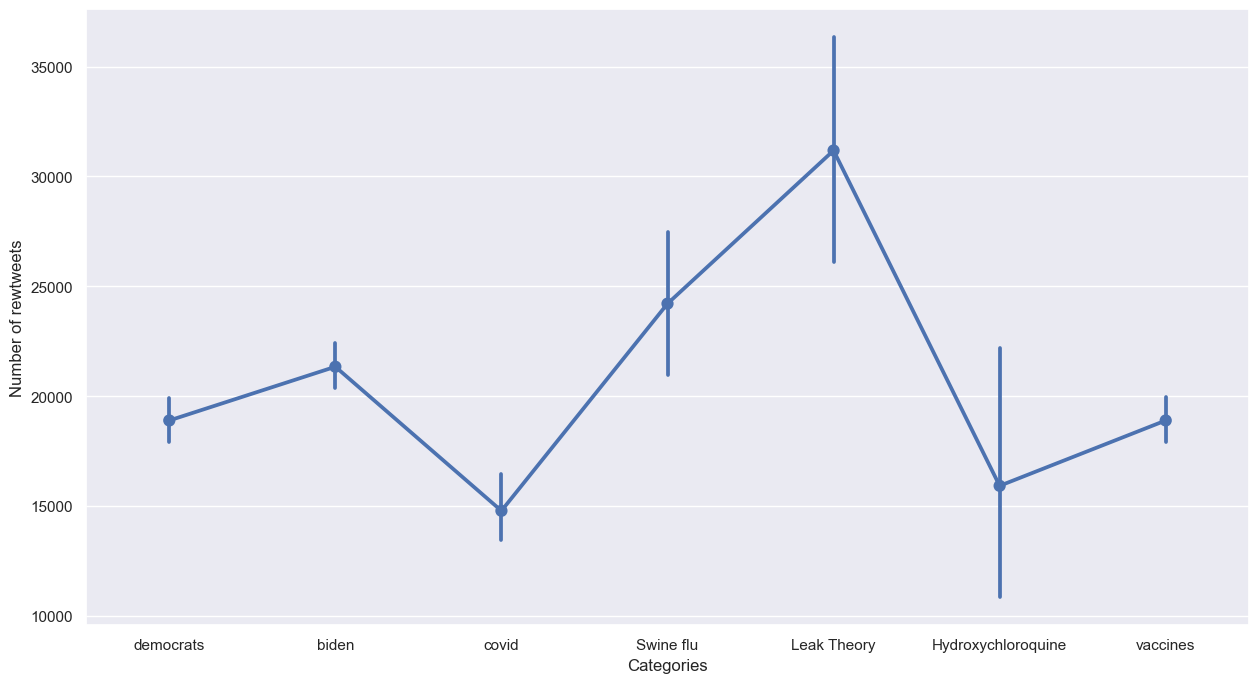

In [32]:
ax = sns.pointplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

# Studying sentiment

Add one hot encoding of sentiment:

In [33]:
data =data.merge(pd.get_dummies(data['sentiment_type']), left_index=True, right_index=True)

## Sentiment distributions

sentiment_type
POSITIVE    6085
NEGATIVE    3789
NEUTRAL     3644
Name: count, dtype: int64


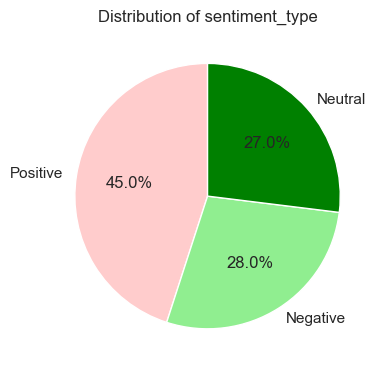

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(4, 4))

var = 'sentiment_type'
colors = ['#FFCCCC', 'lightgreen','green']
print(data[var].value_counts())
plt.pie(data[var].value_counts(), labels=['Positive', 'Negative','Neutral'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title(f'Distribution of {var}')

plt.tight_layout()

**DT is actually a positive guy!**

Show a few tweets:

In [36]:
data[data.sentiment_type=='POSITIVE'].text

1        ....in America, community by community where w...
2        On World AIDS Day, The First Lady and I expres...
6        RT @CNBC: This year is shaping up to be one of...
7        Just landed in the United Kingdom, heading to ...
8        The Fed should lower rates (there is almost no...
                               ...                        
13510    Mike Pence didn’t have the courage to do what ...
13511    Please support our Capitol Police and Law Enfo...
13512    I am asking for everyone at the U.S. Capitol t...
13514    These are the things and events that happen wh...
13517    The 75,000,000 great American Patriots who vot...
Name: text, Length: 6085, dtype: object

In [37]:
data[data.sentiment_type=='NEUTRAL'].text

4        “Trump did nothing impeachable, day-by-day rev...
10                                 https://t.co/zlfV4MOkom
12       "RT @thehill: #BREAKING: Ukraine's Zelensky: I...
26       “The Democrats don’t have any evidence, but th...
27       Breaking News: The President of Ukraine has ju...
                               ...                        
13507                          Even Mexico uses Voter I.D.
13509                              https://t.co/izItBeFE6G
13513                              https://t.co/Pm2PKV0Fp3
13516                              https://t.co/csX07ZVWGe
13518    To all of those who have asked, I will not be ...
Name: text, Length: 3644, dtype: object

In [38]:
data[data.sentiment_type=='NEGATIVE'].text

0        “Sen. Tim Scott Says Trump 'Innocent,' 'No Way...
3        “Schiff’s impeachment hearings wasting time wh...
5        Mini Mike Bloomberg has instructed his third r...
23       Heading to Europe to represent our Country and...
41       RT @RepMarkGreen: President Zelensky has repea...
                               ...                        
13495    RT @TomiLahren: The steal is in the making in ...
13498    Get smart Republicans. FIGHT! https://t.co/3fs...
13501    If Vice President @Mike_Pence comes through fo...
13505    They just happened to find 50,000 ballots late...
13506    The States want to redo their votes. They foun...
Name: text, Length: 3789, dtype: object

## Retweets per sentiment :

[Text(0.5, 1.0, 'Number of retweets per sentiment category')]

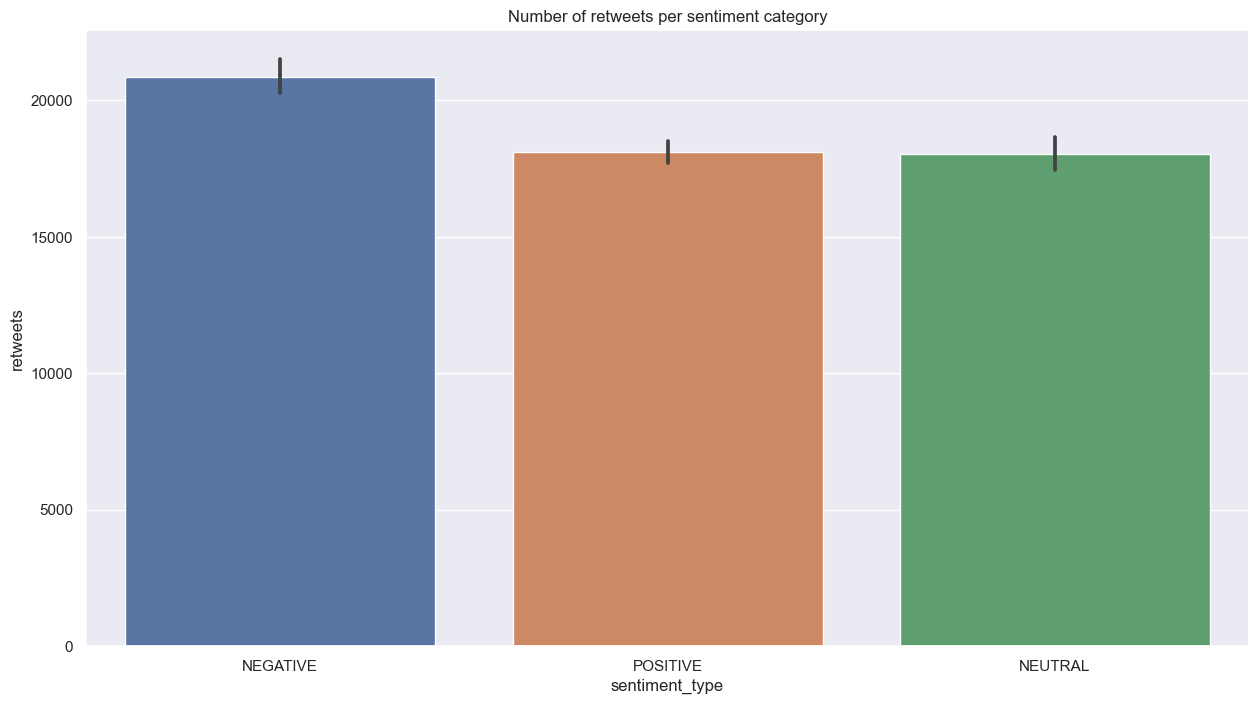

In [39]:
sns.barplot(data,x='sentiment_type',y='retweets').set(title='Number of retweets per sentiment category')


## Study relation between categories and sentiments:

In [40]:
pivot_dem = pd.crosstab(data[data['democrats']==True].democrats, data['sentiment_type'])
pivot_biden = pd.crosstab(data[data['biden']==True].biden, data['sentiment_type'])
pivot_covid = pd.crosstab(data[data['covid_related']==True].covid_related, data['sentiment_type'])
pivot_fake_news = pd.crosstab(data[data['is_fake_news']==True].is_fake_news, data['sentiment_type'])
pivot_vaccines = pd.crosstab(data[data['vaccines']==True].vaccines, data['sentiment_type'])

pivot_df = pd.concat([pivot_dem,pivot_biden,pivot_covid,pivot_fake_news,pivot_vaccines])
#pivot_df.reindex(index=['is_democrats_related','is_covid_related','is_fake_news_related','is_vaccines_related'])

In [41]:
proportion_df = 100*pivot_df.div(pivot_df.sum(axis=1), axis=0)
proportion_df

sentiment_type,NEGATIVE,NEUTRAL,POSITIVE
True,48.519362,13.097950,38.382688
True,44.317181,19.471366,36.211454
True,31.987578,21.739130,46.273292
True,68.888889,8.888889,22.222222
True,48.519362,13.097950,38.382688


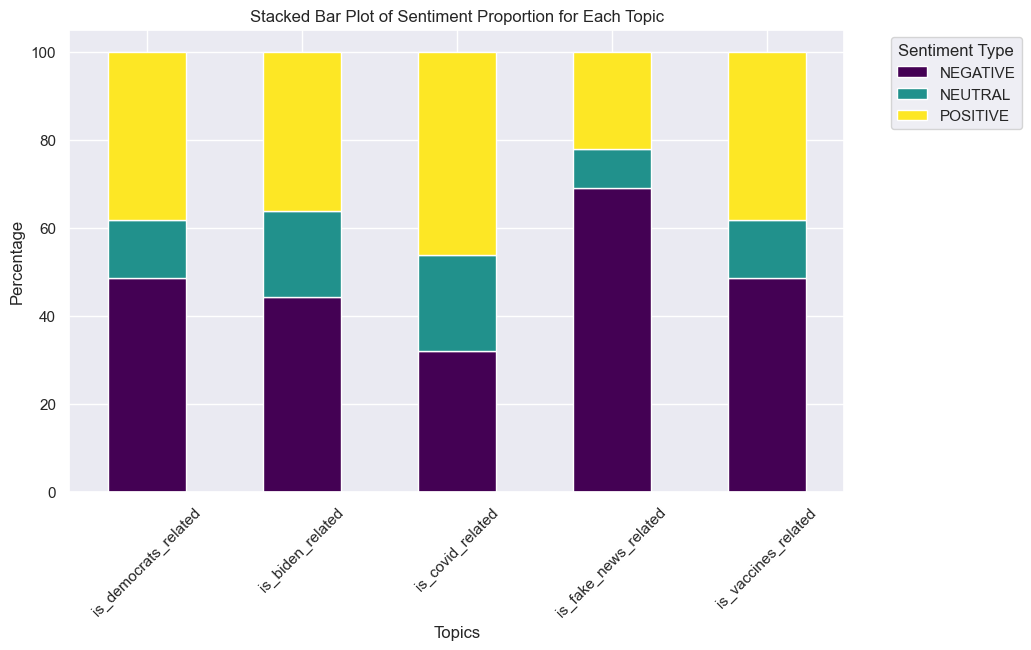

In [42]:
ax = proportion_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Stacked Bar Plot of Sentiment Proportion for Each Topic')
ax.set_xticklabels(['is_democrats_related','is_biden_related','is_covid_related','is_fake_news_related','is_vaccines_related'])
plt.xlabel('Topics')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')

## Retweets per sentiment for given categories ( to delete I guess)

[Text(0.5, 1.0, 'Number of retweets per sentiment category for covid related tweets')]

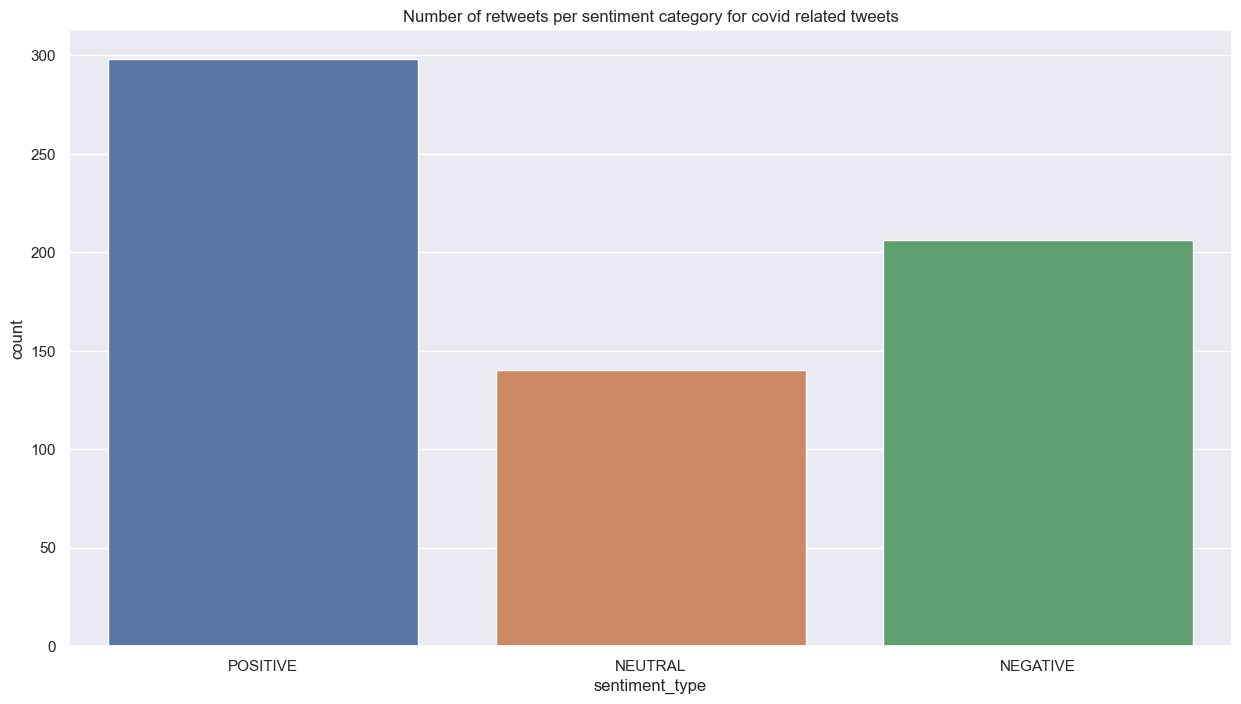

In [43]:

sns.countplot(data_covid_rel, x="sentiment_type").set(title='Number of retweets per sentiment category for covid related tweets')

[Text(0.5, 1.0, 'Number of retweets per sentiment categoryfor biden related tweets')]

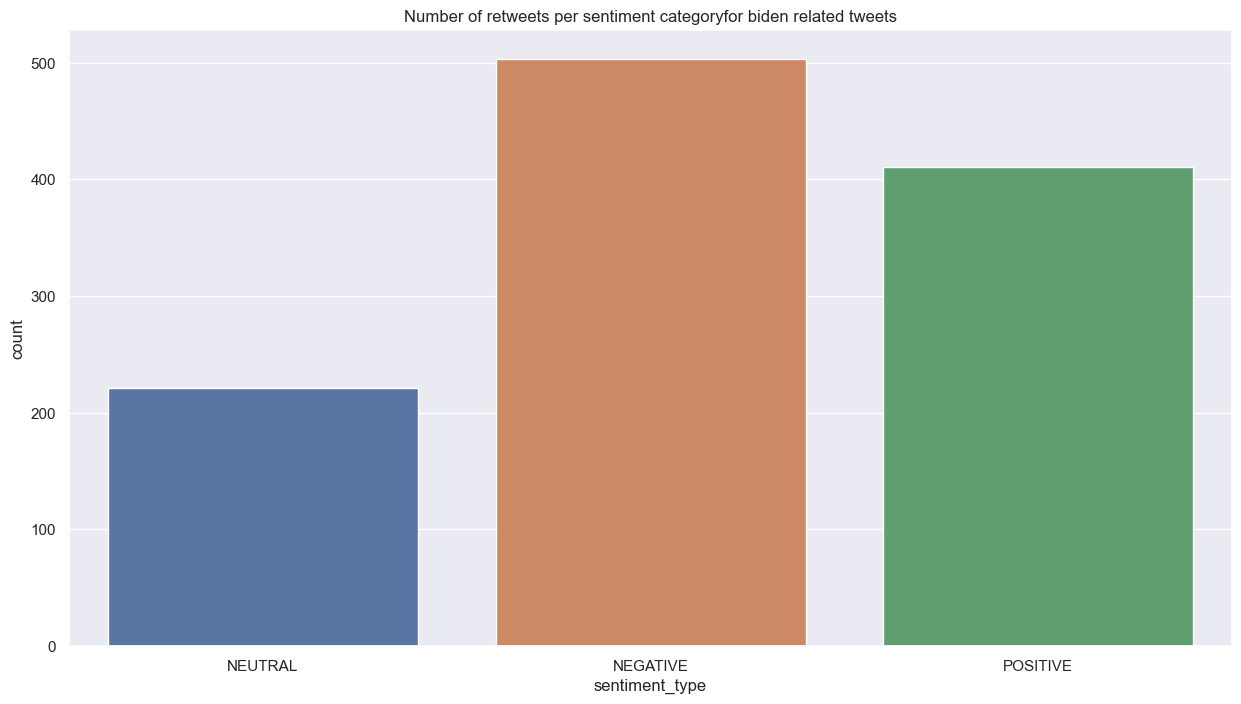

In [44]:
sns.countplot(data_biden_rel, x="sentiment_type").set(title='Number of retweets per sentiment categoryfor biden related tweets')

**Caution: some 'positive' are actually sarcastic:**

In [45]:
data_biden_rel[data_biden_rel.sentiment_type=='POSITIVE'].text[1720]

'Crazy Bernie takes the lead in the Democrat Primaries, but it is looking more and more like the Dems will never allow him to win! Will Sleepy Joe be able to stumble across the finish line?'

## Regression with one hotted categories :

In [46]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)+C(NEGATIVE)+C(POSITIVE)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     24.43
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.44e-24
Time:                        10:36:37   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13512   BIC:                         3.033e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Covid ot big impacts but democrats does, negative has a significant positive impact
how to make meaningful regression?

## Biden related

In [18]:
biden = ['Joe Biden','biden','joe','Joe','Biden','sleepy']
analyze_biden = data['text'].apply(lambda x: True if any(word in x for word in biden) else False)

# create a new column with the result of the analysis
new_col = analyze_biden.reindex(data.index, fill_value=False)
data['biden'] = new_col
print('Number of tweets talking about biden is: ', data['biden'].sum())


Number of tweets talking about biden is:  1135


In [19]:
data_biden_rel = data[data['biden']==1]
data_not_biden_rel = data[data['biden']==0]
comparison_biden = pd.DataFrame({'biden related':data_biden_rel.retweets, 'Non biden related':data_not_biden_rel.retweets})

t_stat, p_value_biden = ttest_ind(data_biden_rel.retweets, data_not_biden_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_biden.round(5))

The p-value of the t-test is 0.0


## Democrats related

In [20]:
democrats = ['Democrats','democrats','Dems','dems']
analyze_democrats = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_democrats.reindex(data.index, fill_value=False)
data['democrats'] = new_col
print('Number of tweets talking about democrats is: ', data['democrats'].sum())

Number of tweets talking about democrats is:  878


In [21]:
data_democrats_rel = data[data['democrats']==1]
data_not_democrats_rel = data[data['democrats']==0]
comparison_democrats = pd.DataFrame({'democrats related':data_democrats_rel.retweets, 'Non democrats related':data_not_democrats_rel.retweets})

t_stat, p_value_democrats = ttest_ind(data_democrats_rel.retweets, data_not_democrats_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_democrats.round(5))

The p-value of the t-test is 0.92457


## Vaccines related

In [22]:
vaccines = ['vaccines','Vaccines','vax','Vax','vaccin']
analyze_vaccines = data['text'].apply(lambda x: True if any(word in x for word in democrats) else False)

# create a new column with the result of the analysis
new_col = analyze_vaccines.reindex(data.index, fill_value=False)
data['vaccines'] = new_col
print('Number of tweets talking about vaccines of the t-test is: ', data['vaccines'].sum())

Number of tweets talking about vaccines of the t-test is:  878


In [23]:
data_vaccines_rel = data[data['vaccines']==1]
data_not_vaccines_rel = data[data['vaccines']==0]
comparison_vaccines = pd.DataFrame({'vaccines related':data_vaccines_rel.retweets, 'Non vaccines related':data_not_vaccines_rel.retweets})


t_stat, p_value_vaccines = ttest_ind(data_vaccines_rel.retweets, data_not_vaccines_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_vaccines.round(5))

The p-value of the t-test is 0.92457


## Aggregate results into more general categories:

In [24]:
data['is_fake_news'] = (data['Hydroxychloroquine']|data['Swineflu']|data['Leaktheory'])
data['is_democrats_related'] = (data['biden']|data['democrats'])

In [25]:
data['is_democrats_related'] .sum()

1936

In [26]:
data_fake_news_rel = data[data['is_fake_news']==1]
data_not_fake_news_rel = data[data['is_fake_news']==0]
comparison_fake_news = pd.DataFrame({'fake_news related':data_fake_news_rel.retweets, 'Non fake_news related':data_not_fake_news_rel.retweets})


t_stat, p_value_fake_news = ttest_ind(data_fake_news_rel.retweets, data_not_fake_news_rel.retweets, equal_var=False)
print('The p-value of the t-test is', p_value_fake_news.round(5))

The p-value of the t-test is 8e-05


## Plots of number of rewteets by topics:

[Text(0, 0.5, 'Number of retweets')]

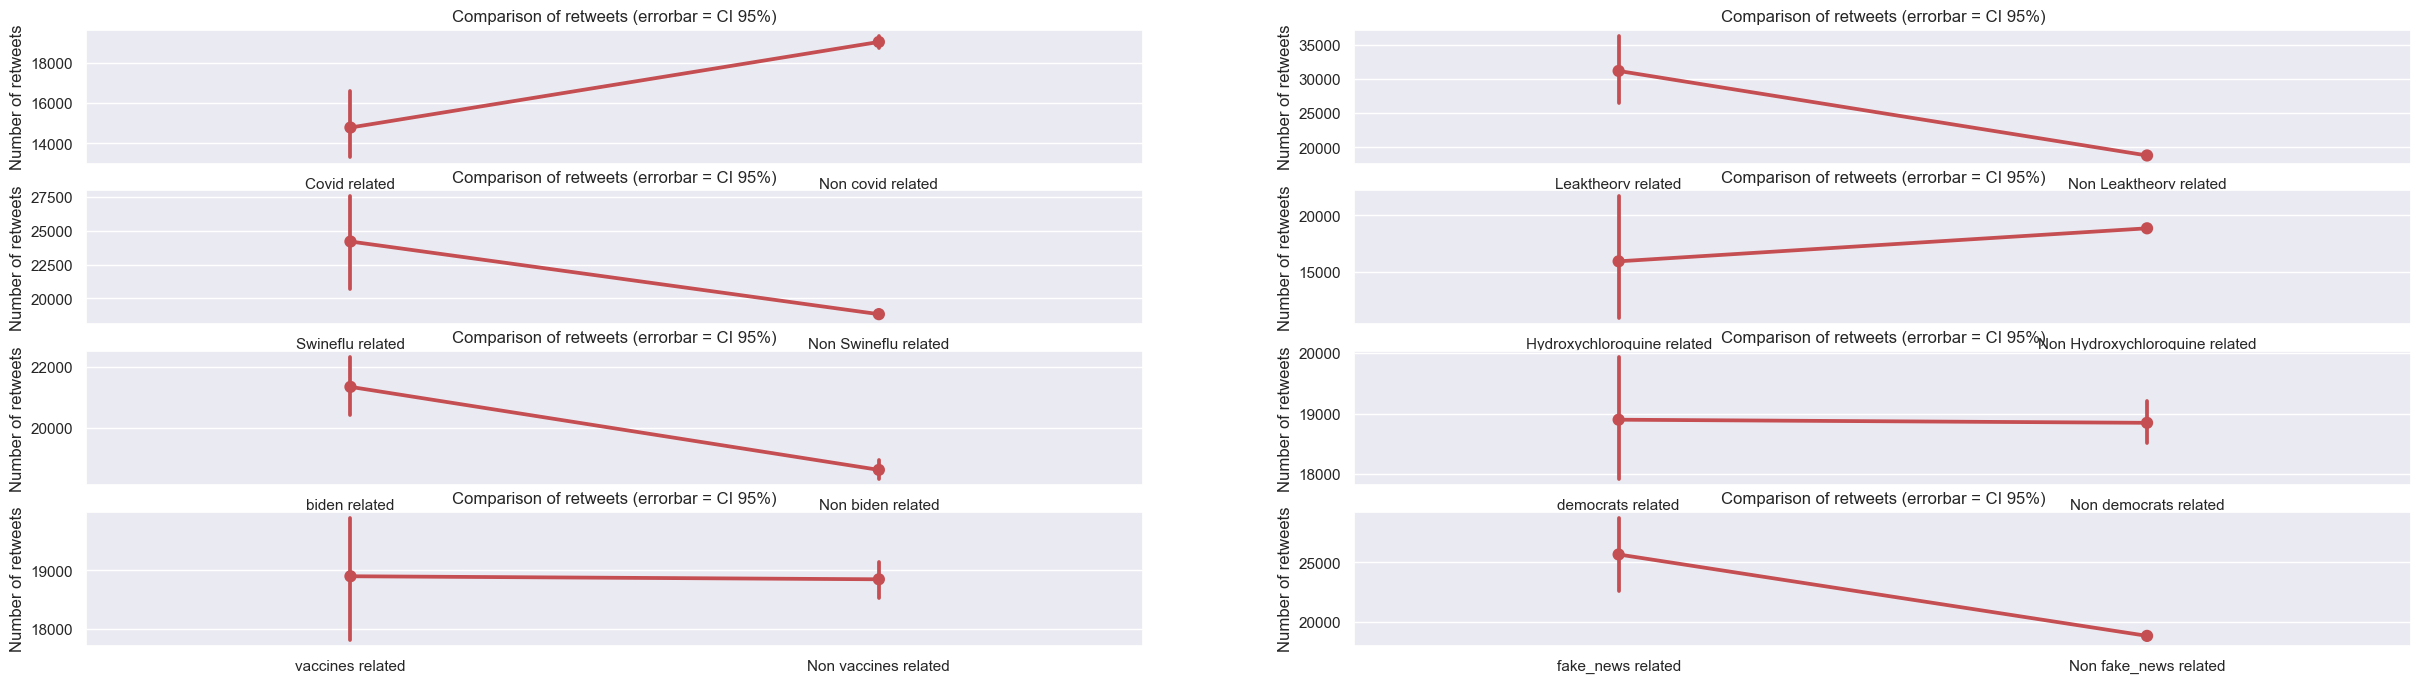

In [27]:
fig, axs = plt.subplots(4, 2,figsize=(30,8))

ax0 = sns.pointplot(data=comparison_covid, ax=axs[0, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax0 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax0 .set(ylabel='Number of retweets')

ax1 = sns.pointplot(data=comparison_Leaktheory,ax=axs[0, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax1 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax1 .set(ylabel='Number of retweets')

ax2 = sns.pointplot(data=comparison_Swineflu, ax=axs[1, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax2 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax2 .set(ylabel='Number of retweets')

ax3 = sns.pointplot(data=comparison_Hydroxychloroquine, ax= axs[1, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax3 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax3 .set(ylabel='Number of retweets')

ax4 = sns.pointplot(data=comparison_biden,ax=axs[2, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax4 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax4 .set(ylabel='Number of retweets')

ax5 = sns.pointplot(data=comparison_democrats, ax=axs[2, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax5 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax5 .set(ylabel='Number of retweets')

ax6 = sns.pointplot(data=comparison_vaccines, ax=axs[3, 0], estimator='mean', errorbar=('ci', 95), color = 'r')
ax6 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax6 .set(ylabel='Number of retweets')

ax7 = sns.pointplot(data=comparison_fake_news, ax=axs[3, 1], estimator='mean', errorbar=('ci', 95), color = 'r')
ax7 .set(title='Comparison of retweets (errorbar = CI 95%)')
ax7 .set(ylabel='Number of retweets')

## Regression to disentangle categories into predicting the number of retweets:

In [28]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     22.14
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           2.71e-14
Time:                        10:35:50   Log-Likelihood:            -1.5163e+05
No. Observations:               13518   AIC:                         3.033e+05
Df Residuals:                   13514   BIC:                         3.033e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [29]:
mod_retweets = smf.ols(formula='retweets ~ C(covid_related)+C(is_fake_news)+C(sentiment_type)', data=data)

In [30]:
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     29.59
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.55e-24
Time:                        10:35:50   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13513   BIC:                         3.033e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

## Compare number of retweets per categories :

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

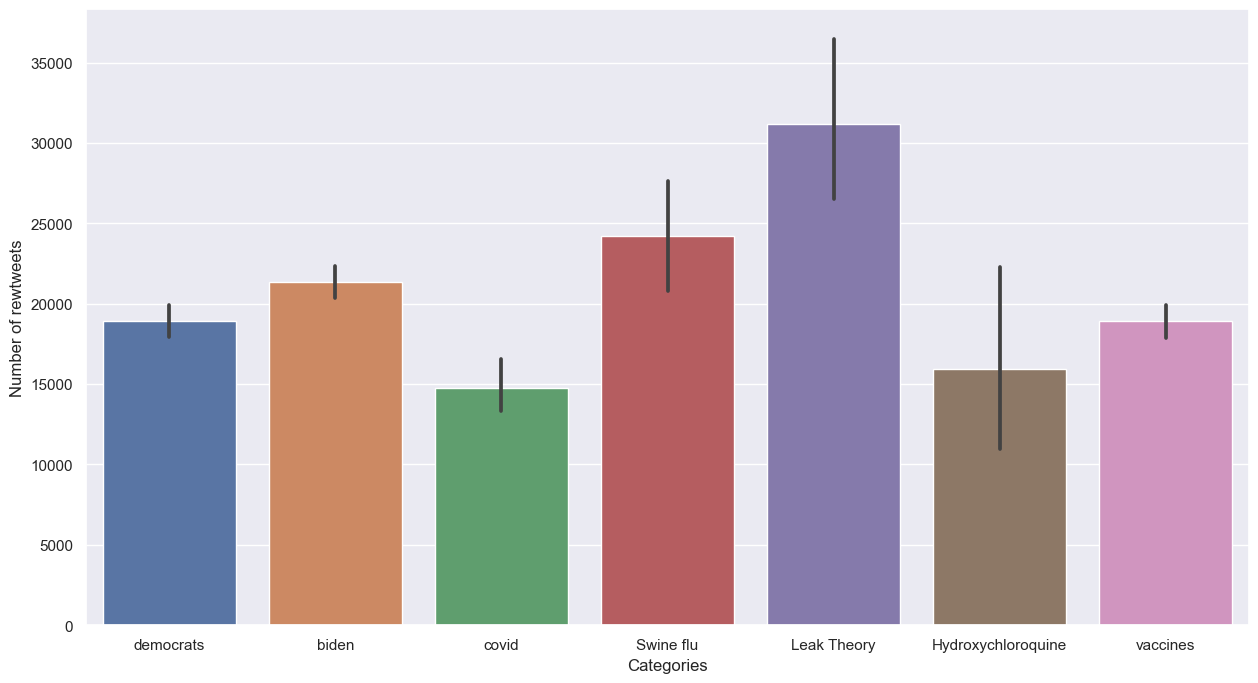

In [31]:
compare_retweets = pd.DataFrame({'democrats':data_democrats_rel.retweets,'biden':data_biden_rel.retweets,
                    'covid':data_covid_rel.retweets,'Swine flu':data_Swineflu_rel.retweets,
                     'Leak Theory':data_Leaktheory_rel.retweets,'Hydroxychloroquine':data_Hydroxychloroquine_rel.retweets,
                               'vaccines':data_vaccines_rel.retweets})

ax = sns.barplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

[Text(0.5, 0, 'Categories'), Text(0, 0.5, 'Number of rewtweets')]

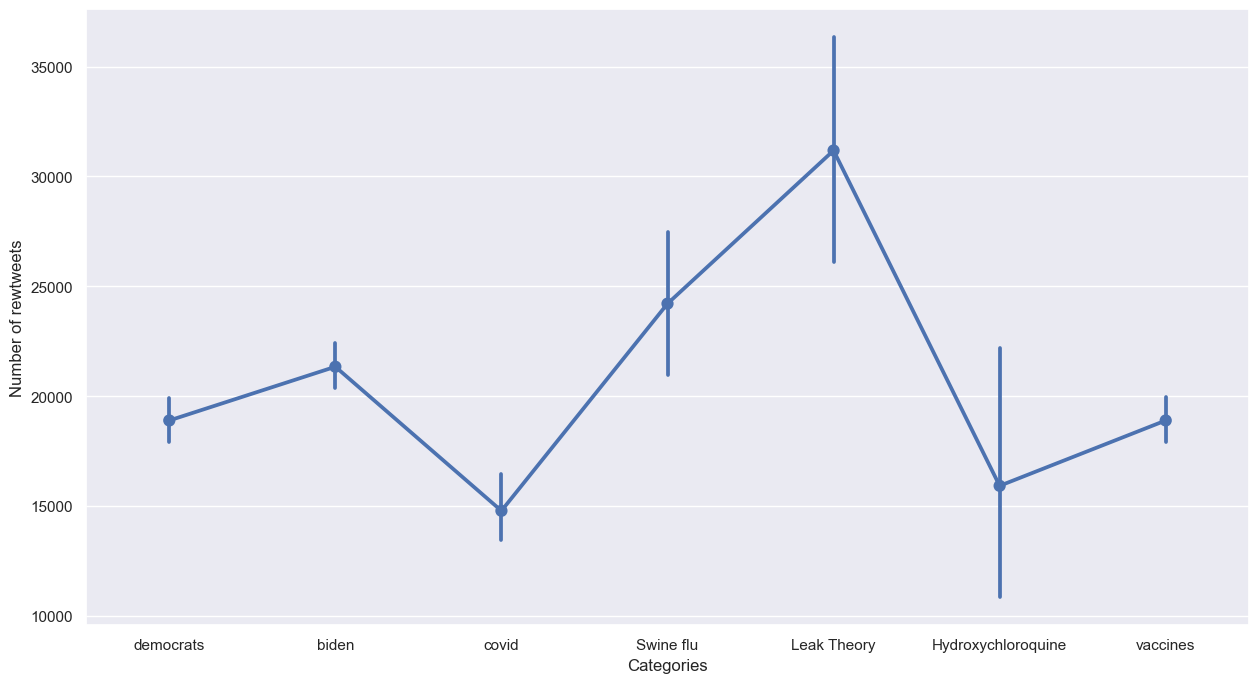

In [32]:
ax = sns.pointplot(compare_retweets)
ax.set(xlabel='Categories', ylabel='Number of rewtweets')

# Studying sentiment

Add one hot encoding of sentiment:

In [33]:
data =data.merge(pd.get_dummies(data['sentiment_type']), left_index=True, right_index=True)

## Sentiment distributions

sentiment_type
POSITIVE    6085
NEGATIVE    3789
NEUTRAL     3644
Name: count, dtype: int64


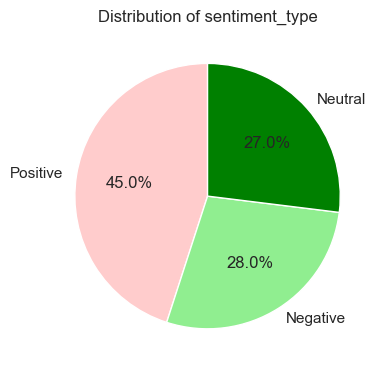

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=False, figsize=(4, 4))

var = 'sentiment_type'
colors = ['#FFCCCC', 'lightgreen','green']
print(data[var].value_counts())
plt.pie(data[var].value_counts(), labels=['Positive', 'Negative','Neutral'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title(f'Distribution of {var}')

plt.tight_layout()

**DT is actually a positive guy!**

Show a few tweets:

In [36]:
data[data.sentiment_type=='POSITIVE'].text

1        ....in America, community by community where w...
2        On World AIDS Day, The First Lady and I expres...
6        RT @CNBC: This year is shaping up to be one of...
7        Just landed in the United Kingdom, heading to ...
8        The Fed should lower rates (there is almost no...
                               ...                        
13510    Mike Pence didn’t have the courage to do what ...
13511    Please support our Capitol Police and Law Enfo...
13512    I am asking for everyone at the U.S. Capitol t...
13514    These are the things and events that happen wh...
13517    The 75,000,000 great American Patriots who vot...
Name: text, Length: 6085, dtype: object

In [37]:
data[data.sentiment_type=='NEUTRAL'].text

4        “Trump did nothing impeachable, day-by-day rev...
10                                 https://t.co/zlfV4MOkom
12       "RT @thehill: #BREAKING: Ukraine's Zelensky: I...
26       “The Democrats don’t have any evidence, but th...
27       Breaking News: The President of Ukraine has ju...
                               ...                        
13507                          Even Mexico uses Voter I.D.
13509                              https://t.co/izItBeFE6G
13513                              https://t.co/Pm2PKV0Fp3
13516                              https://t.co/csX07ZVWGe
13518    To all of those who have asked, I will not be ...
Name: text, Length: 3644, dtype: object

In [38]:
data[data.sentiment_type=='NEGATIVE'].text

0        “Sen. Tim Scott Says Trump 'Innocent,' 'No Way...
3        “Schiff’s impeachment hearings wasting time wh...
5        Mini Mike Bloomberg has instructed his third r...
23       Heading to Europe to represent our Country and...
41       RT @RepMarkGreen: President Zelensky has repea...
                               ...                        
13495    RT @TomiLahren: The steal is in the making in ...
13498    Get smart Republicans. FIGHT! https://t.co/3fs...
13501    If Vice President @Mike_Pence comes through fo...
13505    They just happened to find 50,000 ballots late...
13506    The States want to redo their votes. They foun...
Name: text, Length: 3789, dtype: object

## Retweets per sentiment :

[Text(0.5, 1.0, 'Number of retweets per sentiment category')]

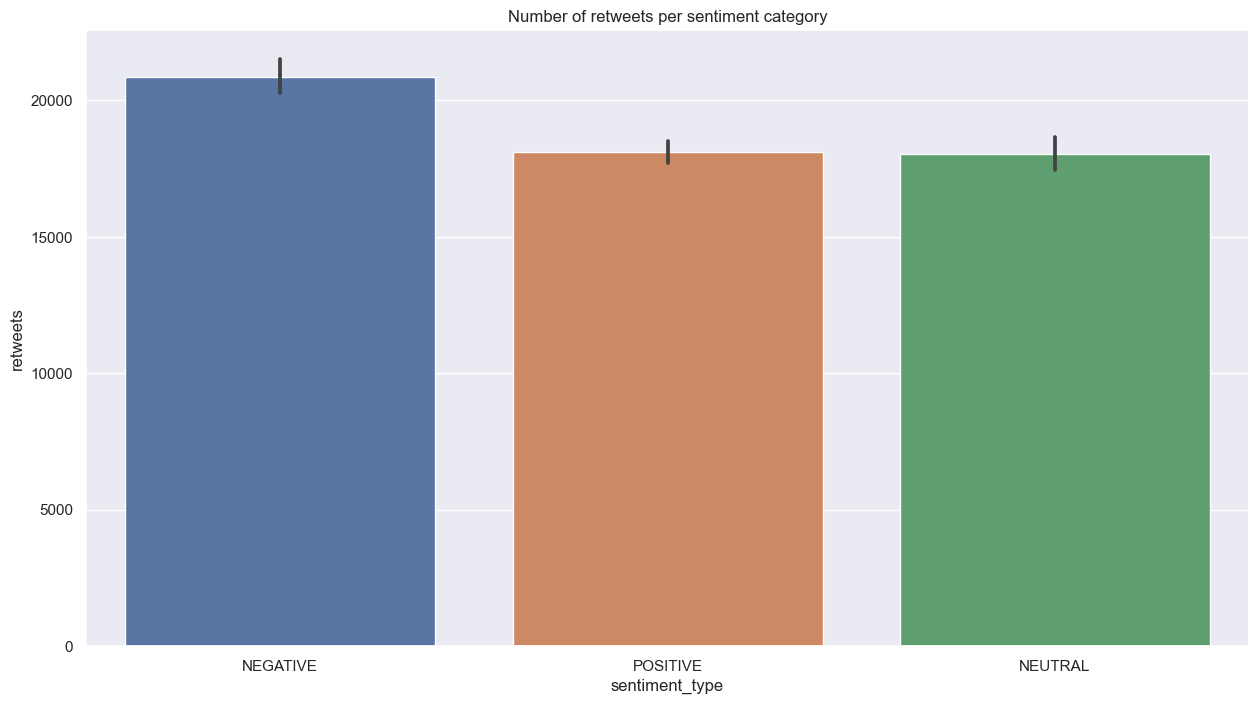

In [39]:
sns.barplot(data,x='sentiment_type',y='retweets').set(title='Number of retweets per sentiment category')


## Study relation between categories and sentiments:

In [40]:
pivot_dem = pd.crosstab(data[data['democrats']==True].democrats, data['sentiment_type'])
pivot_biden = pd.crosstab(data[data['biden']==True].biden, data['sentiment_type'])
pivot_covid = pd.crosstab(data[data['covid_related']==True].covid_related, data['sentiment_type'])
pivot_fake_news = pd.crosstab(data[data['is_fake_news']==True].is_fake_news, data['sentiment_type'])
pivot_vaccines = pd.crosstab(data[data['vaccines']==True].vaccines, data['sentiment_type'])

pivot_df = pd.concat([pivot_dem,pivot_biden,pivot_covid,pivot_fake_news,pivot_vaccines])
#pivot_df.reindex(index=['is_democrats_related','is_covid_related','is_fake_news_related','is_vaccines_related'])

In [41]:
proportion_df = 100*pivot_df.div(pivot_df.sum(axis=1), axis=0)
proportion_df

sentiment_type,NEGATIVE,NEUTRAL,POSITIVE
True,48.519362,13.097950,38.382688
True,44.317181,19.471366,36.211454
True,31.987578,21.739130,46.273292
True,68.888889,8.888889,22.222222
True,48.519362,13.097950,38.382688


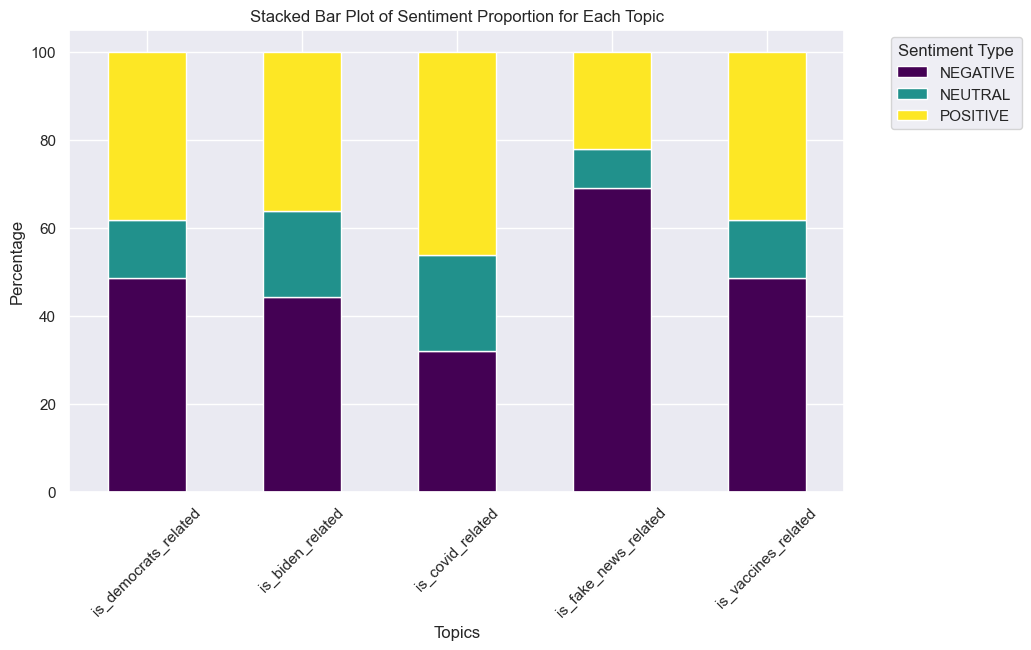

In [42]:
ax = proportion_df.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title('Stacked Bar Plot of Sentiment Proportion for Each Topic')
ax.set_xticklabels(['is_democrats_related','is_biden_related','is_covid_related','is_fake_news_related','is_vaccines_related'])
plt.xlabel('Topics')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Sentiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')

## Retweets per sentiment for given categories ( to delete I guess)

[Text(0.5, 1.0, 'Number of retweets per sentiment category for covid related tweets')]

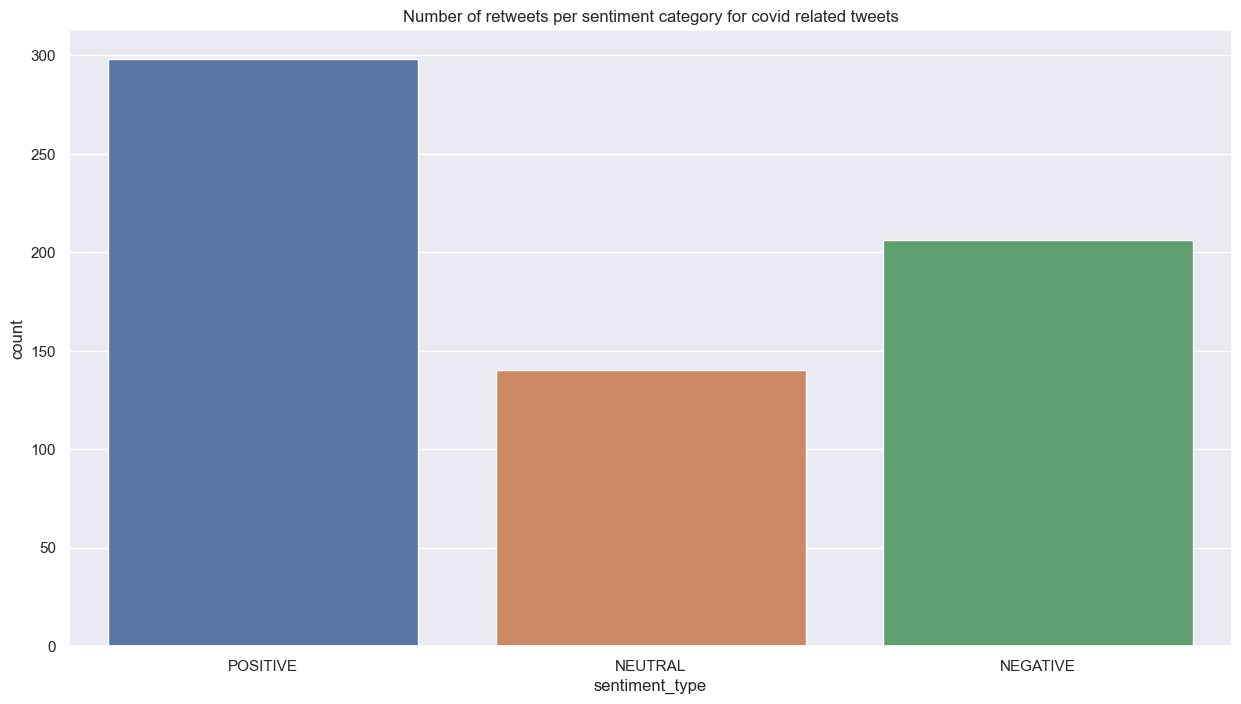

In [43]:

sns.countplot(data_covid_rel, x="sentiment_type").set(title='Number of retweets per sentiment category for covid related tweets')

[Text(0.5, 1.0, 'Number of retweets per sentiment categoryfor biden related tweets')]

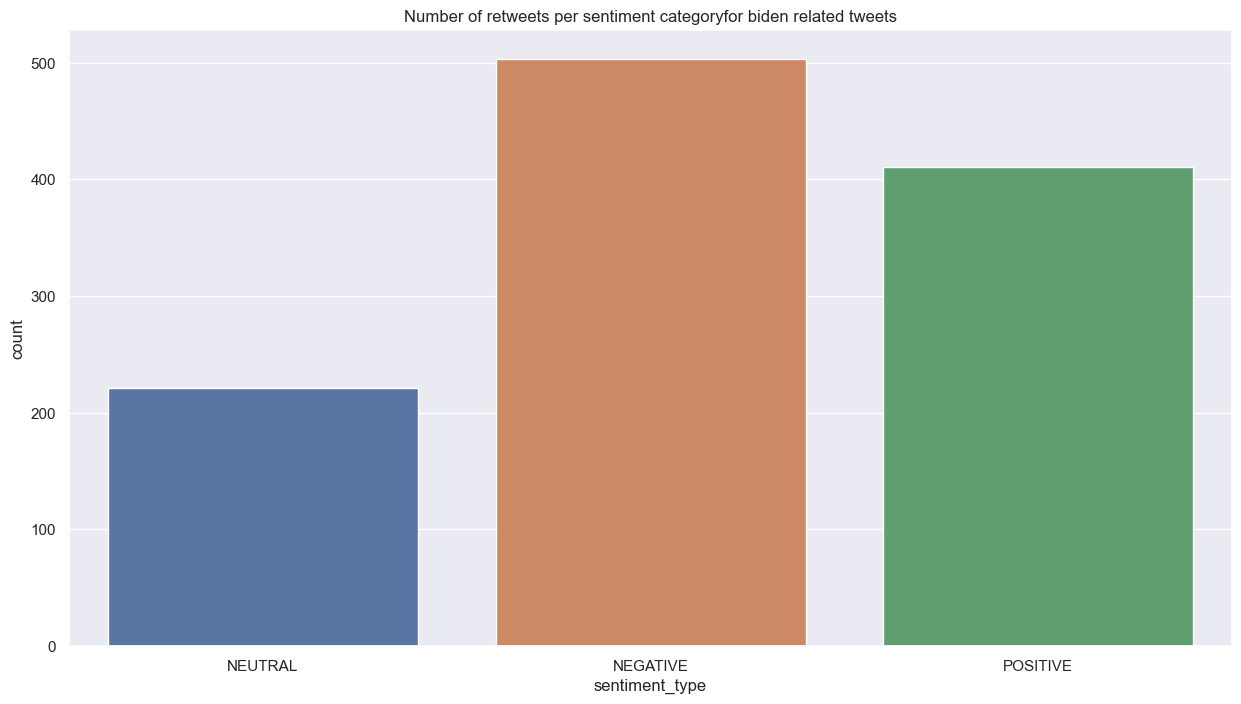

In [44]:
sns.countplot(data_biden_rel, x="sentiment_type").set(title='Number of retweets per sentiment categoryfor biden related tweets')

**Caution: some 'positive' are actually sarcastic:**

In [45]:
data_biden_rel[data_biden_rel.sentiment_type=='POSITIVE'].text[1720]

'Crazy Bernie takes the lead in the Democrat Primaries, but it is looking more and more like the Dems will never allow him to win! Will Sleepy Joe be able to stumble across the finish line?'

## Regression with one hotted categories :

In [46]:
mod_retweets = smf.ols(formula='retweets ~ C(is_democrats_related)+C(covid_related)+C(is_fake_news)+C(NEGATIVE)+C(POSITIVE)', data=data)
res_retweets = mod_retweets.fit()
print(res_retweets.summary())

                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     24.43
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.44e-24
Time:                        10:36:37   Log-Likelihood:            -1.5160e+05
No. Observations:               13518   AIC:                         3.032e+05
Df Residuals:                   13512   BIC:                         3.033e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Covid ot big impacts but democrats does, negative has a significant positive impact
how to make meaningful regression?

# Part 4: Causal Analysis 

In [1]:
# modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
from causalimpact import CausalImpact
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

# helpers
from helpers.wiki_gtrend_visualization import load_wikipedia_df
from helpers.gtrend_visualization import load_gtrend_df, load_gtrend_hourly_df
from helpers.load_topic_hourly import request_gtrends

One of our research questions is to find whether there is a causal relationship between Trump's tweets and the number of visits on some Covid-related topics, for example Hydroxychloroquine on Wikipedia. During COVID-19 period Trump claimed that Hydroxychloroquine was a cure for COVID-19. This claim was not supported by scientific evidence, making it more of a fake news. This was further motivation to investigate this topic in particular.

## 4.1 Pre-processing

In [2]:
tweets_df = pd.read_csv('data/tweets.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')

This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
tweets_df.loc[1, 'date']

Timestamp('2020-03-03 01:34:50')

Let's focus on the Covid period:

In [4]:
tweets_covid_df = tweets_df[tweets_df['date'] >= '2019-12-01'].copy()
tweets_covid_df.sort_values(by='date')
tweets_covid_df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56,f


## 4.2 Wikipedia & GTrends Time Series

Let's see the number of tweets where Hydroxychloroquine is mentioned:

In [5]:
# Pinpoint all tweets containing the key words
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = tweets_covid_df['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# Create a column with a boolean indicating whether tweet contains a key word
new_col = analyze.reindex(tweets_covid_df.index, fill_value=False)
tweets_covid_df['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', tweets_covid_df['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [6]:
# get the dates where trump spoke about Hydroxychloroquine
hydro_tweets_times = tweets_covid_df[tweets_covid_df['Hydroxychloroquine'] == True]['date'].copy()
hydro_tweets_times = hydro_tweets_times.sort_values()
hydro_tweets_times = hydro_tweets_times.reset_index(drop=True)
hydro_tweets_times = hydro_tweets_times.dt.normalize() # set times to 00:00:00
display(hydro_tweets_times.head())
week_critical_data_hydro = (hydro_tweets_times - pd.to_timedelta((hydro_tweets_times.dt.dayofweek+1) % 7, unit='D')).unique()

0   2020-03-21
1   2020-03-24
2   2020-04-04
3   2020-04-05
4   2020-04-10
Name: date, dtype: datetime64[ns]

We want to get the global number of pageviews for the article related to hydroxychloroquine from Wikipedia and Google Trends. We will start by graphically studying the evolution of the number of queries/visits to assess whether Trump's tweets had an impact on them.

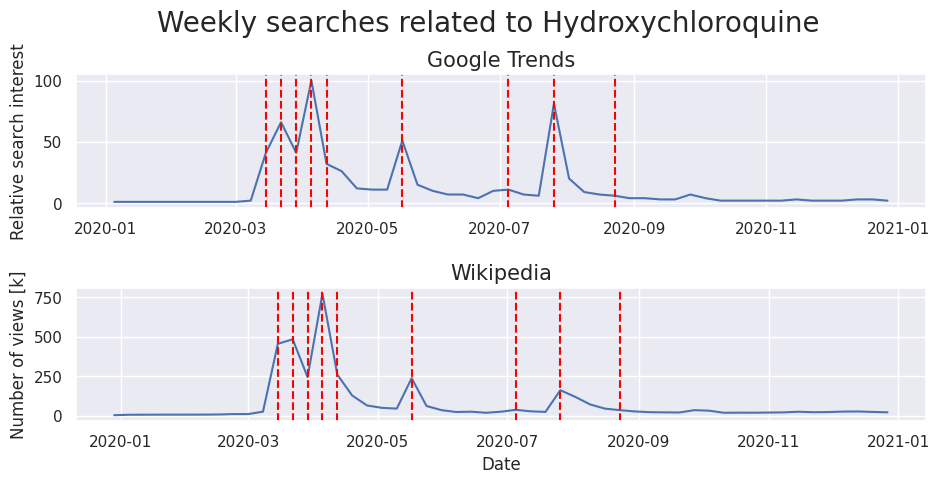

In [7]:
pagename = 'Hydroxychloroquine'
folder = 'extra_material'
filename = 'hydroxychloroquine'

weekly_wikipedia_hydro_df, daily_wikipedia_hydro_df = load_wikipedia_df(folder,filename)
gtrends_hydro_df = load_gtrend_df(folder, filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)
daily_wikipedia_hydro_df

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_hydro_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_hydro_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data_hydro]
axis[1].set_xlabel('Date')

plt.show()

As we can see, the Wikipedia and Google trend pageviews behave simarly. Google Trends uses a relative scale from 0 to 100, while Wikipedia returns the absolute number of visits. We can see that the number of visits was almost zero until March 2020. The spikes in the graph appear almost at the same time as Trump's Tweet. We should further investigate whether there is a causal relationship between Trump's tweets and the number of visits.

To get a finer visualization of the impact of Trump's tweets on Wikipedia searches, we can also plot Wikipedia searches on hydroxychloroquine at a daily granularity (this granularity is not available on Google Trends).

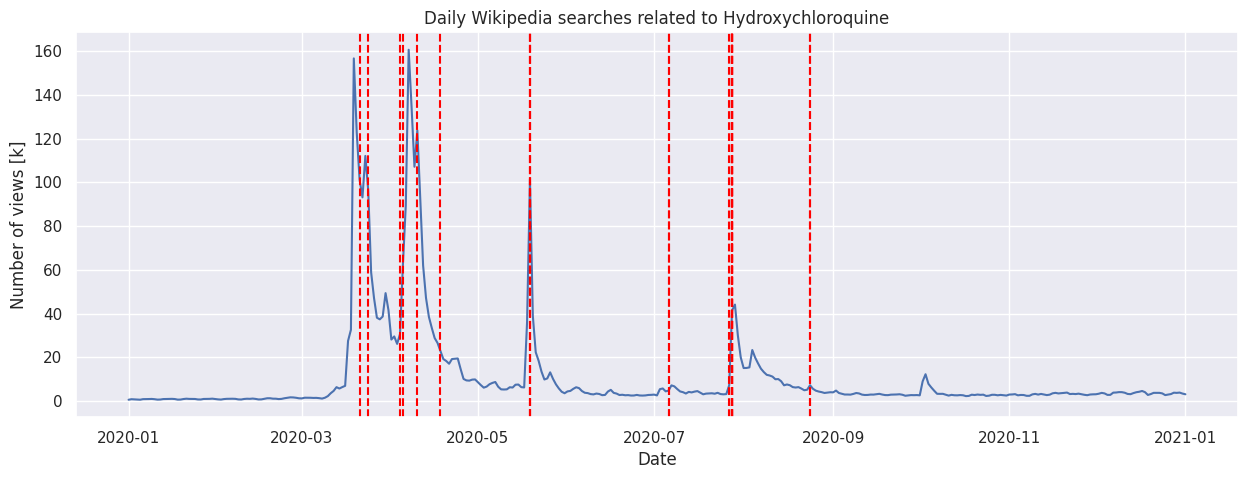

In [23]:
plt.figure(figsize = (15, 5))

plt.title('Daily Wikipedia searches related to {pagename}'.format(pagename=pagename))
plt.ylabel('Number of views [k]')
plt.plot(daily_wikipedia_hydro_df['Views']/10**3)
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in hydro_tweets_times]
plt.xlabel('Date')
plt.show()

As we can see from the graph above, Trump's tweets on hydroxychloroquine seem to precede certain attention peaks (e.g. the second big peak at the start of April), but come after others (e.g. the first big peak, around mid-March). A possibile explanation is simply that the tweets sometimes cause attention, whereas other times public interests makes Trump tweet about the topic. Another one is that both are caused by external factors, and that Trump's and the public's reaction times vary: sometimes Trump reacts the fastest, and other times the public does.

As hydroxychloroquine  was not the only fake news spread by Trump, we repeated the same preliminary analysis and visualizations for other fake news, to get a better idea of how well our observations for hydroxychloroquine generalize to other topics.

### 1)  Swine Flu

Trump tweeted a lot about the Swine Flu. Let's graphically study the relationship between Trump's tweets and public interest for the topic.

Number of tweets talking about Swine Flu is:  26


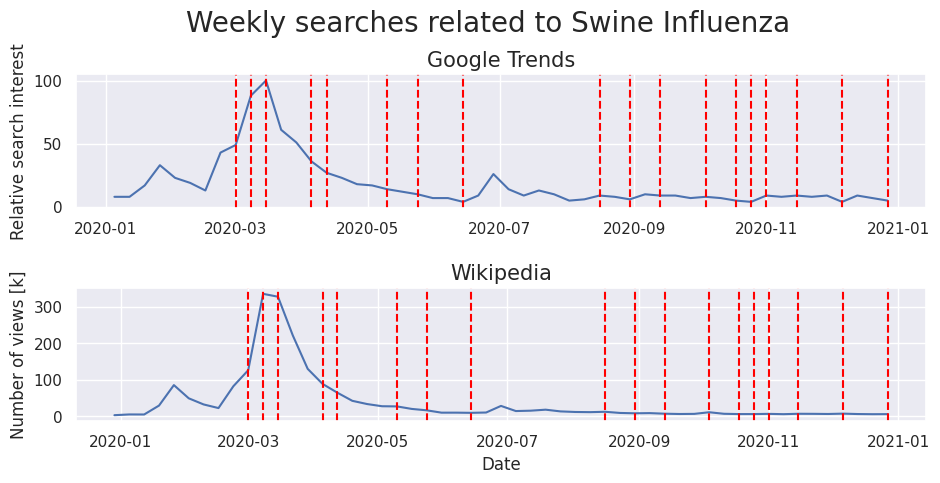

In [24]:
fake_news_swineflu = ['Swine', 'swine', 'H1N1', 'h1n1']
analyze_swineflu = data['text'].apply(lambda x: True if any(word in x for word in fake_news_swineflu) else False)

# create a new column with the result of the analysis
new_col = analyze_swineflu.reindex(data.index, fill_value=False)
data['Swineflu'] = new_col
print('Number of tweets talking about Swine Flu is: ', data['Swineflu'].sum())

# get the dates where trump spoke
critical_data = data[data['Swineflu'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'Swine Influenza'
filename = 'swineflu'

weekly_wikipedia_df, _ = load_wikipedia_df(folder, filename)
gtrends_df = load_gtrend_df(folder, filename)

fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename}'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis[0].set_title('Google Trends', size=15)
axis[0].set_ylabel('Relative search interest')
axis[0].plot(gtrends_df['Views'])
[axis[0].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

axis[1].set_title('Wikipedia', size=15)
axis[1].set_ylabel('Number of views [k]')
axis[1].plot(weekly_wikipedia_df['Views']/10**3)
[axis[1].axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]
axis[1].set_xlabel('Date')

plt.show()

From the plot, it seems that peaks in popularity tend to start before Trump's tweets (especially the first two), but some of Trump's tweets might still have had some effect. His first tweet seemed to have increased the slope of the main popularity peak, and his tweets in mid-june 2020 might have cause the subsequent peak in interest (a smaller one, but Trump's tweet clearly precedes it this time).

### 2)  China Laboratory-Leak Virus

Trump was not tweeting directly about the fact that covid escaped from a lab, however, he tweeted a lot about the "China Virus", did this feed the trend?

Number of tweets talking about COVID-19 lab leak theory is:  44


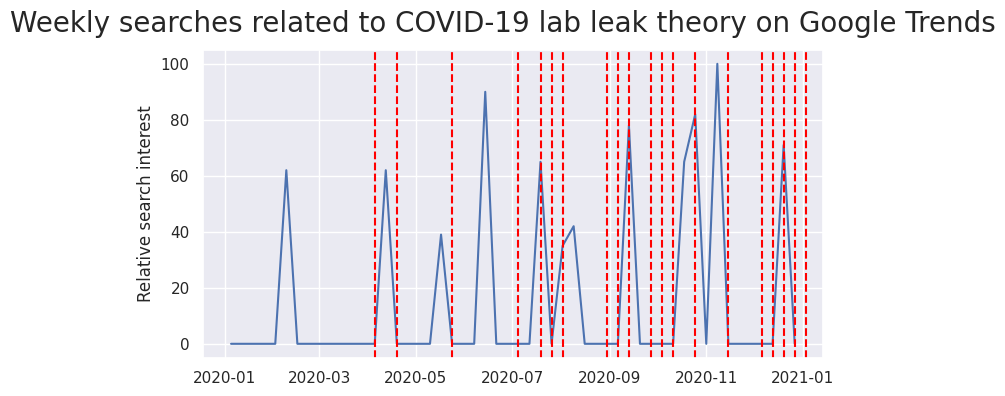

In [25]:
fake_news_leaktheory = ['China virus', 'china virus', 'chinavirus', 'Chinavirus', 'China Virus']
analyze_leaktheory = data['text'].apply(lambda x: True if any(word in x for word in fake_news_leaktheory) else False)

# create a new column with the result of the analysis
new_col = analyze_leaktheory.reindex(data.index, fill_value=False)
data['Leaktheory'] = new_col
print('Number of tweets talking about COVID-19 lab leak theory is: ', data['Leaktheory'].sum())

# get the dates where trump spoke
critical_data = data[data['Leaktheory'] == True]['date']
week_critical_data = (critical_data - pd.to_timedelta((critical_data.dt.dayofweek+1) % 7, unit='D')).unique()
            
pagename = 'COVID-19 lab leak theory'
filename = 'leaktheory'

weekly_wikipedia_df, _ = load_wikipedia_df(folder, filename)
gtrends_df = load_gtrend_df(folder, filename)

plt.figure(figsize=(8, 4)) 

plt.suptitle('Weekly searches related to {pagename} on Google Trends'.format(pagename=pagename), size=20)

plt.ylabel('Relative search interest')
plt.plot(gtrends_df['Views'])
[plt.axvline(x=critical_date, color='red', linestyle='--') for critical_date in week_critical_data]

plt.show()

For the 'Lab Leak Theory' the graph is much more hectic and it's hard to conclude on any causal effect of Trump's tweets on online trends.

## 4.3 Granger Causality

To better understand Trump's potential causal impact on online trends, we will focus on the topic of hydroxychloroquine. 
The plot of daily Wikipedia views made it difficult to assess whether Trump causes tweets or the other way around. To investigate this, we therefore chose to conduct a [Granger causality](https://en.wikipedia.org/wiki/Granger_causality) test. 

"The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another".
The [null hypothesis](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.grangercausalitytests.html) is that "the the time series the first column is NOT Granger caused by the time series in the other columns".

In [8]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=daily_wikipedia_hydro_df['Views'].index, columns=['Date'])

for date in hydro_tweets_times:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine wiki and tweets
wiki_tweets_hydro_df = daily_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)
display(wiki_tweets_hydro_df.sample(5))

,Views,Tweets
Date,,
2020-12-22,3711,0
2020-06-03,5530,0
2020-02-03,856,0
2020-01-14,885,0
2020-02-28,1452,0


First, let's investigate whether tweets Granger cause views.

In [9]:
print("\n DO TWEETS GRANGER CAUSE VIEWS? \n")
tweets_cause_views = grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2, verbose=False)

print(f"p-value, 1 lag: {tweets_cause_views[1][0]['ssr_ftest'][1]}")
print(f"p-value, 2 lags: {tweets_cause_views[2][0]['ssr_ftest'][1]}")


 DO TWEETS GRANGER CAUSE VIEWS? 

p-value, 1 lag: 2.577509249130668e-05
p-value, 2 lags: 1.7666280235258212e-06


/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


The p-values for the Granger causality tests for both lags 1 and 2 are well below the threshold of 0.05. The test is therefore statistically signifcant and the views time series is Granger caused by tweets.


Let's repeat our analysis the other way around: do views Granger cause Trump's tweets?

In [10]:
print("DO VIEWS GRANGER CAUSE TWEETS?")
views_cause_tweets = grangercausalitytests(wiki_tweets_hydro_df, 2, verbose=False)

print(f"p-value, 1 lag: {views_cause_tweets[1][0]['ssr_ftest'][1]}")
print(f"p-value, 2 lags: {views_cause_tweets[2][0]['ssr_ftest'][1]}")

DO VIEWS GRANGER CAUSE TWEETS?
p-value, 1 lag: 0.8244239959804691
p-value, 2 lags: 0.008218461970936052


This time, only the p-value for 2 lags is below the statistical threshold of significance of 0.05. According to [Wikipedia](https://en.wikipedia.org/wiki/Granger_causality), however, "the null hypothesis of no Granger causality is not rejected if and only if no lagged values of an explanatory variable have been retained in the regression". In other words, having signifance for one lagged value is enough. We can thus conclude that views also cause Trump's tweets.

How to interpret the fact that the two time series Granger cause each other? As mentioned earlier, Granger causality just means that one time series is useful at predicting the other. There can therefore be two explanations to our results:
- sometimes Trump causes tweets, other times public interest causes Trump to tweet;
- or both time series are actually caused by external factors. Sometimes Trump's reacts faster, and sometimes the public get interested first. The varying reaction times could explain the Granger causality results.

## 4.4 Causal Impact

To further investigate whether Trump's tweet cause views, we will focus on his first tweet, which coincides with a big peak in interest (both on Wikipedia and Google).
The [Causal Impact](https://google.github.io/CausalImpact/CausalImpact.html) library in Python allows us perform a test which can tell us if there is a causal relation between Trump's first tweet and the number of Google queries on Hydroxychloroquine. We are focusing on Google Trends, as they allows us to study time series at hourly granularity. 
To run this analysis we need to build a dataframe with the following columns:
- data index: the date of the observation of our time series.
- y: the number of visits to the the page of Hydroxychloroquine (test variable).
- x: the number of visits to a set of pages (the control variables), which were not affected by the intervention (Trump's first tweet).

The following [assumptions](https://pypi.org/project/pycausalimpact/) need to be verified to conduct this test : "the response variable can be precisely modeled by a linear regression with what is known as "covariates" (or X) that must not be affected by the intervention that took place".

We decided to take the time series of the following five topics, which for obvious reasons should not have been affected by Trump's tweet, as control variables: climate, coffee, news, shop and time.

### A) Fetch GTrends Time Series at Hourly Granularity

We start by fetching the time series of interest from Google Trends. We focus on a window of 4 days centred around Trump's first tweet. Note that we are using the time series of global searches on hydroxychloroquine. Unfortunately, more local series were not available for the data of interest.

In [11]:
# Select tweet number
tweet_nb = 0
alias = f"tweet_{tweet_nb}"

# Request data from GTrends API (both hydro and Google) and save it
tweet_time = hydro_tweets_times[tweet_nb].replace(minute=0, second=0)
print(f"Time of Trump's first tweet: {tweet_time}")
start_time = tweet_time - timedelta(hours=48)
end_time = tweet_time + timedelta(hours=48)

# # Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Time of Trump's first tweet: 2020-03-21 00:00:00


In [12]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)
folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

,hydro,climate,coffee,news,shop,time
Date,,,,,,
2020-03-19 00:00:00,12,66,78,70,63,90
2020-03-19 01:00:00,38,65,93,69,60,95
2020-03-19 02:00:00,36,85,83,66,59,88
2020-03-19 03:00:00,17,100,74,64,55,90
2020-03-19 04:00:00,14,77,71,71,57,91


### B) Causal Impact

We then select the pre-period (time before Trump's tweet) and the post-period (the time after his tweet) for the causal analysis.

In [13]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], tweet_time]
post_period = [tweet_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

[Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-21 00:00:00')]
[Timestamp('2020-03-21 01:00:00'), Timestamp('2020-03-23 00:00:00')]


We verify the assumption that the test variable can be modelled as a linear regression with the covariates.

In [27]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hydro   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     5.833
Date:                Tue, 19 Dec 2023   Prob (F-statistic):            0.00106
Time:                        15:21:38   Log-Likelihood:                -37.945
No. Observations:                  31   AIC:                             87.89
Df Residuals:                      25   BIC:                             96.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.0069      2.701     -2.594      0.016     -12.570      -1.443
coffee         0.0148      0.022      0.670      0.509      -0.031       0.060
climate        0.0532      0.019      2.766      0.011       0.014       0.093
news           0.0516      0.018      2.801      0.010       0.014       0.090
shop           0.0213      0.027      0.776      0.445      -0.035       0.078
time           0.0037      0.022      0.164      0.871      -0.042       0.050
==============================================================================
Omnibus:                        6.749   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                2.202
Skew:                           0.211   Prob(JB):                        0.333
Kurtosis:                       1.765   Cond. No.                     2.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p-values associated with several coefficientss are significant (< 0.05), and the R² = 0.54. The fit is therefore pretty good, but the results of our causal analysis should still be interpreted with caution.

We can now run the causal impact analysis.

/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. Th

[0, 48]


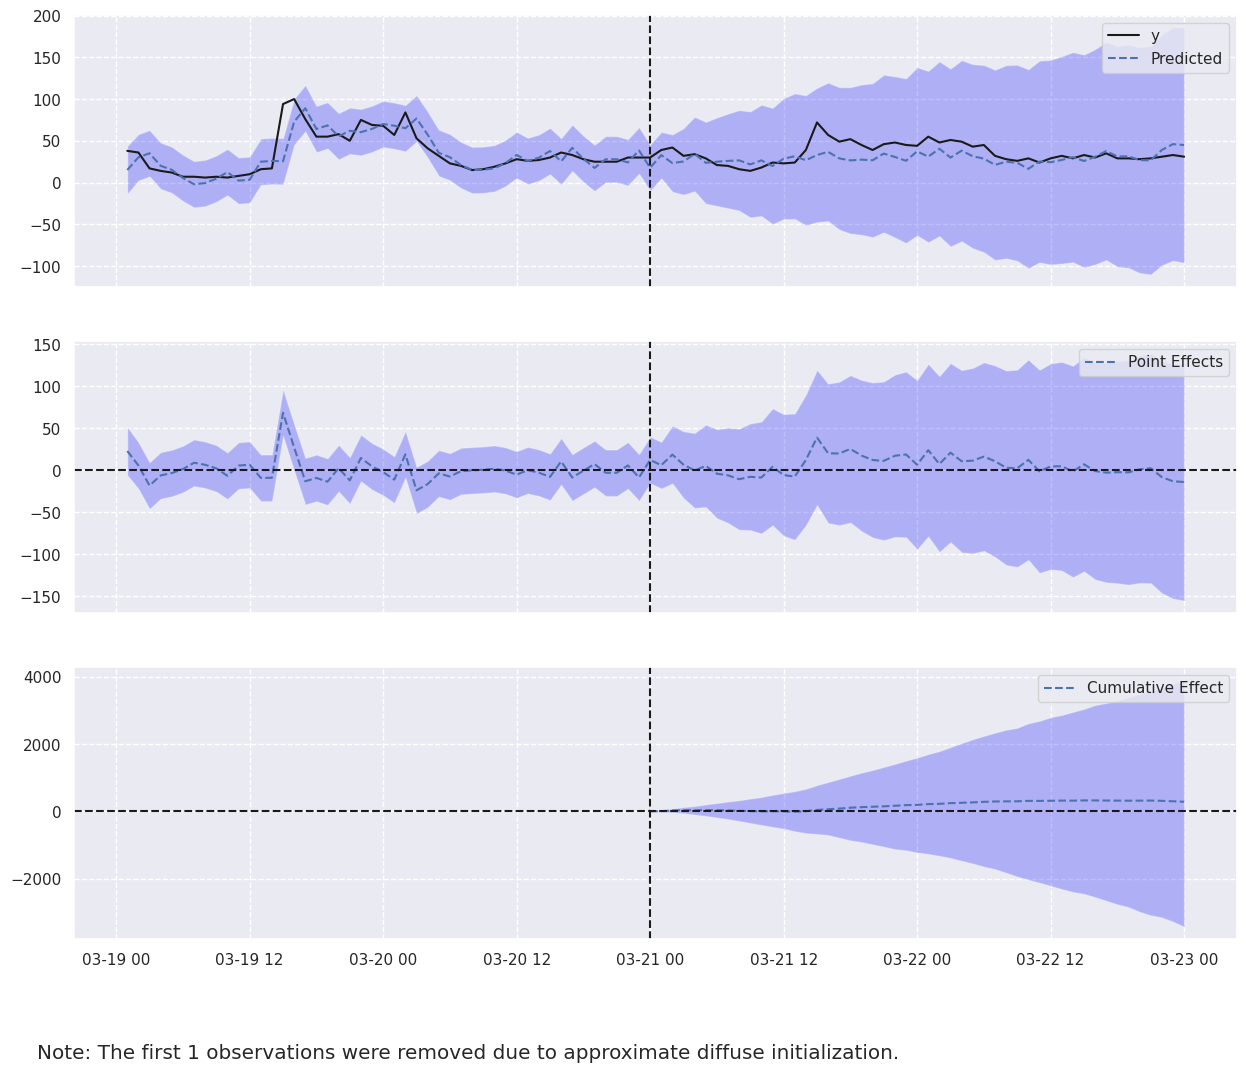

In [15]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()

The causal impact analysis corroborates the visual inspection of the Google Trends time series: the peak in interest on hydroxychloroquine preceded Trump's first tweet. His tweet therefore doesn't seem to have had a strong impact on interest. Note, however, that we are using global trends time series. It might be that Trump had a local impact (though probably not strong) on Google searches, e.g. in the United States.

### D) Alternative Hypothesis

As explained earlier, an alternative possibility to explain why online trends time series and Trump's tweets Granger cause each other is that an external factor is the "real" cause of the surge of interest.

Some online research revealed that the big peak in interest mid-March might have caused by the two following major events, which both took place on March 16, 2020:
- a mobility changepoint in the United States following restrictions, according to [Manoel et al.](https://arxiv.org/abs/2005.08505),
- "A study on the use of hydroxychloroquine in patients with SARS-CoV-2 was published (online via Youtube) - The preliminary data from this small study was heard round the world", as quoted from [Saag et al.](https://jamanetwork.com/journals/jama/fullarticle/2772921).

We therefore tried to reconduct a causal impact analysis, considering March 16, 5 P.M. (GMT, so between 9 A.M and 12 A.M. in the USA) as our intervention time.

Again, we start by fetching the global data over a window of 4 days (not exactly centred around the chosen intervention time due to data unavailability on Google Trends).

In [28]:
# Request data from GTrends API (both hydro and Google) and save it
treatment_time = pd.Timestamp(2020,3,16,17,0,0)
print(f"Tweet time: {treatment_time}")
start_time = pd.Timestamp(2020,3,15,12,0,0)
end_time = pd.Timestamp(2020,3,19,12,0,0)

print(f"start time: {start_time}")
print(f"end time: {end_time}")

alias = "publi"

# Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'y
# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Tweet time: 2020-03-16 17:00:00
start time: 2020-03-15 12:00:00
end time: 2020-03-19 12:00:00


In [29]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

,hydro,climate,coffee,news,shop,time
Date,,,,,,
2020-03-15 12:00:00,2,30,74,61,85,63
2020-03-15 13:00:00,2,34,81,69,88,58
2020-03-15 14:00:00,1,40,87,60,85,66
2020-03-15 15:00:00,1,39,85,61,100,66
2020-03-15 16:00:00,1,39,82,59,86,63


We then select the pre- and post-periods for the causal analysis.

In [30]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], treatment_time]
post_period = [treatment_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

[Timestamp('2020-03-15 12:00:00'), Timestamp('2020-03-16 17:00:00')]
[Timestamp('2020-03-16 18:00:00'), Timestamp('2020-03-19 12:00:00')]


Before conducting the analysis, we verify the assumption that the time series can me modelled by a linear regression in the pre-period.

In [31]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hydro   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     5.238
Date:                Tue, 19 Dec 2023   Prob (F-statistic):            0.00217
Time:                        15:57:29   Log-Likelihood:                -36.501
No. Observations:                  30   AIC:                             85.00
Df Residuals:                      24   BIC:                             93.41
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.6160      2.717     -2.435      0.023     -12.223      -1.009
coffee         0.0120      0.022      0.541      0.593      -0.034       0.058
climate        0.0520      0.019      2.709      0.012       0.012       0.092
news           0.0450      0.019      2.323      0.029       0.005       0.085
shop           0.0216      0.027      0.789      0.438      -0.035       0.078
time           0.0074      0.023      0.329      0.745      -0.039       0.054
==============================================================================
Omnibus:                        5.574   Durbin-Watson:                   1.395
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                2.156
Skew:                           0.286   Prob(JB):                        0.340
Kurtosis:                       1.818   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Several coefficients show statistical significance (p-value < 0.05) and the R²=0.52 is fairly high. Still, the results should once more be interpreted with caution.

We can now run the causal impact analysis.

/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. Th

[0, 29]


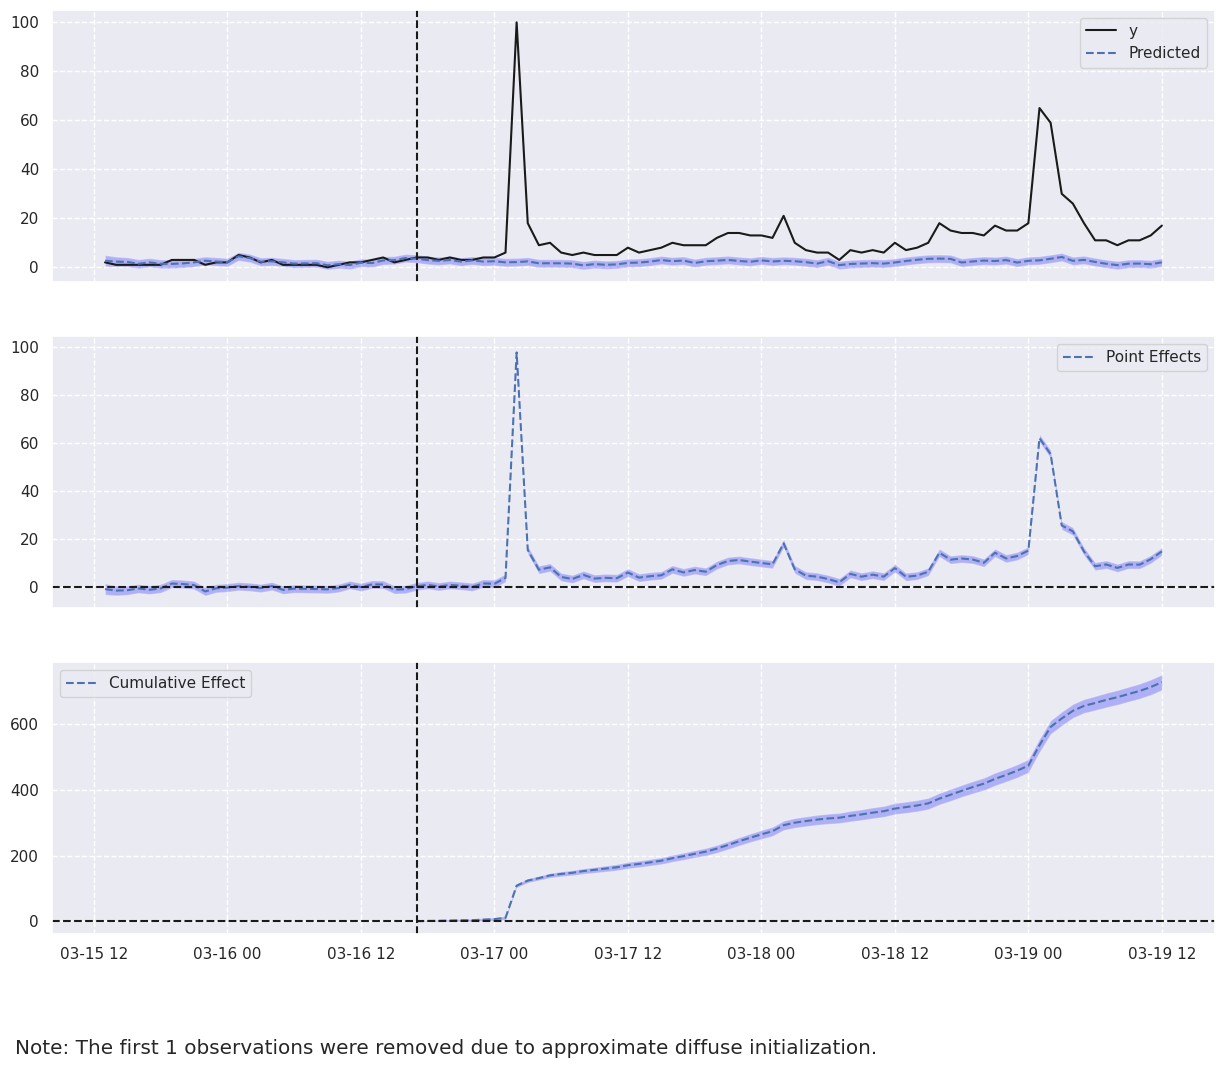

In [32]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()

The causal impact analysis shows that the intervention on March 16 (the mobility restrictions, the publication or both - perhaps even other events, this period was quite hectic) has a strong impact on Google Trends searches on Wikipedia. 

In conclusion, Trump's tweets and online Trends are correlated, and both time series contain information that can predict the other (cf. Granger causality). A focus on the first tweet suggests that rather than the tweets causing public online interest or vice versa, it is quite likely that external events were the real cause of interest. This closer analysis was only conducted on one of his tweets and for one topic, however. The results should therefore be interpreted with caution, and a more systematic study should be done to generalize our observations.